思路：

本方案实现分类任务，通过获取样本60个尾部序列，划分为以30天为界的两类进行训练和预测


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data_V_CURV_CUR (InputLay [(None, 170, 2)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 170, 16)      48          input_data_V_CURV_CUR[0][0]      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 170, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 170, 16)      272         leaky_re_lu[0][0]                
_____________

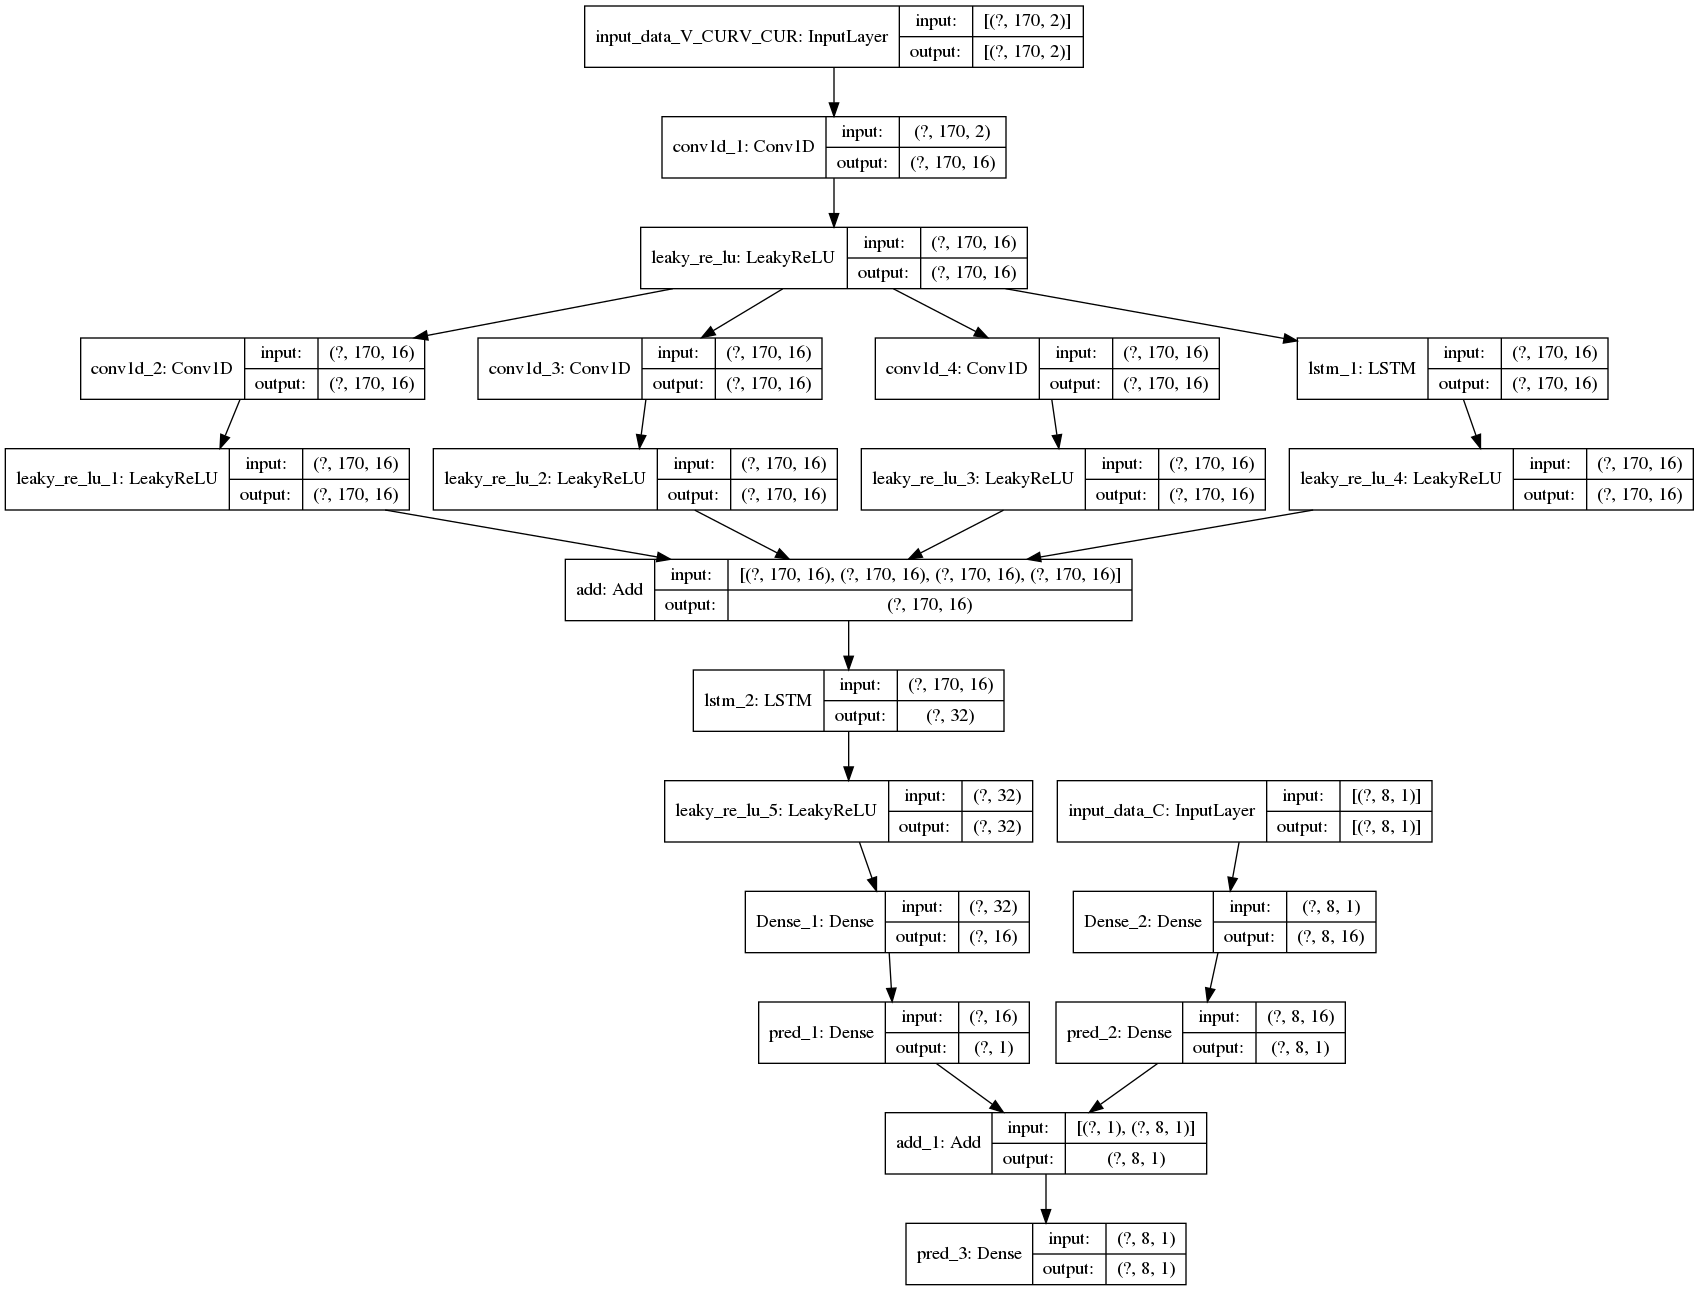

In [1]:
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow.keras.models as M # Sequential, Model

def build_model_Test_1(optimizer, data_size1, data_size2):
    # 定义输入
    input_data_1 = L.Input(shape=data_size1, name='input_data_V_CURV_CUR')
    input_data_2 = L.Input(shape=data_size2, name='input_data_C')


    # 时序分支
    conv1d_1 = L.Conv1D(filters=16, kernel_size=1, padding='same', 
                     input_shape=data_size1,name="conv1d_1")(input_data_1)
    conv_1_2 = L.LeakyReLU()(conv1d_1)
    conv1d_2 = L.Conv1D(filters=16, kernel_size=1,padding='same', 
                     input_shape=data_size1,name="conv1d_2")(conv_1_2)
    conv_2_2 = L.LeakyReLU()(conv1d_2)
    conv1d_3 = L.Conv1D(filters=16, kernel_size=3, activation='relu',padding='same', 
                     input_shape=data_size1,name="conv1d_3")(conv_1_2)
    conv_3_2 = L.LeakyReLU()(conv1d_3)
    conv1d_4 = L.Conv1D(filters=16, kernel_size=4, activation='relu',padding='same', 
                     input_shape=data_size1,name="conv1d_4")(conv_1_2)
    conv_4_2 = L.LeakyReLU()(conv1d_4) 
    lstm_1   = L.LSTM(16,input_shape=data_size1,return_sequences=True,name='lstm_1')(conv_1_2)
    lstm_1_2 = L.LeakyReLU()(lstm_1) 

    add_1    = L.Add()([conv_2_2, conv_3_2, conv_4_2, lstm_1_2])
    lstm_2   = L.LSTM(32,name='lstm_2')(add_1)
    lstm_2_2 = L.LeakyReLU()(lstm_2) 
    Dense_1  = L.Dense(16, activation='sigmoid',name="Dense_1")(lstm_2_2)
    pred_1   = L.Dense(1, activation='sigmoid',name="pred_1")(Dense_1)

    # 逻辑分支
    Dense_2  = L.Dense(16, activation='sigmoid', input_shape=data_size2, name="Dense_2")(input_data_2)
    pred_2   = L.Dense(1, activation='sigmoid', name="pred_2")(Dense_2)

    # 合并输出
    add_2    = L.Add()([pred_1, pred_2])
    pred_3   = L.Dense(1, activation='sigmoid', name="pred_3")(add_2)

    inputs = [input_data_1,input_data_2]
    model = M.Model(inputs, pred_3)  
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    model.summary()
    x = "LR_CNNLSTM2"
    return model,x

modell, xx = build_model_Test_1('adam',(170,2),(8,1))
tf.keras.utils.plot_model(modell,to_file='%s_2.png'%xx, show_shapes=True,show_layer_names=True)   


In [1]:
pwd

'/home/user/桌面/22.7-铅酸电池寿命预测项目/code/LSTM'

In [2]:
# 基础工具模块
import numpy as np
np.set_printoptions(threshold=np.inf)
import pandas as pd
import pandas as pd
from openpyxl import load_workbook
import os
import datetime
import matplotlib
matplotlib.use("Agg")#这个设置可以使matplotlib保存.png图到磁盘
import matplotlib.pyplot as plt
import time
import seaborn as sns
from functools import partial

# keras-tf相关模块
import tensorflow as tf
from keras.models import load_model
from tensorflow.python.keras import backend as K  
from tensorflow.keras.models import * # Sequential, Model
from tensorflow.keras.layers import * # Dense, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, GRU, Input
from tensorflow.keras import optimizers, regularizers
# from keras.layers import *
# 导入ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint,TensorBoard,Callback,ReduceLROnPlateau,EarlyStopping
# keras查看GPU模块
from keras.utils import *  # multi_gpu_model, plot_model


# sklearn科学计算模块
# keras-sklearn计算相关模块
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor,KerasClassifier
# sklearn计算模块
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,classification_report,confusion_matrix
from sklearn.svm import SVC
# sklearn数据处理模块
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit,train_test_split,learning_curve

# 版本检测
from numpy import __version__ as np_version, unique, array, mean, argmax
from pandas import __version__ as pd_version, read_csv, DataFrame, concat
from sklearn import __version__ as sk_version
print("numpy version:", np_version)
print("pandas version:", pd_version)
print("scikit-learn version:", sk_version)

#jupyter 中开启该选项，否则不执行
%matplotlib inline 

Using TensorFlow backend.


numpy version: 1.19.5
pandas version: 1.1.5
scikit-learn version: 0.24.2


In [3]:
# 检查GPU信息
from keras.utils import multi_gpu_model
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
# print(os.environ['CUDA_VISIBLE_DEVICES'])

from tensorflow.python.client import device_lib
print('打印可用设备：\n',device_lib.list_local_devices())

from keras import backend as K
print('检查GPU设备：',K.tensorflow_backend._get_available_gpus())

打印可用设备：
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2838962195407348417
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13394049794170909954
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14705388435136660868
physical_device_desc: "device: XLA_GPU device"
]
检查GPU设备： []


In [4]:
# 初始化参数

# 数据路径
data_path = '../../dataset/(以过滤)(以插值)训练样本数据_2.xlsx'

# 数据超参数
Test_ratio = 0.2 # 划分测试集比例
time_windows = 140 # 已剔除数据量小于60样本
index = 2 # 预测标签 0-3:'Service Meter','Working hours','Attrition rate'/'Category'
require_time_seq = 200
category= 'classification' # 指定分类方法
slices_nums = 200 # 分类任务对数据切分要求

In [5]:
# 数据处理相关模块

# 数据读取
# 读取单个文件指定sheet数据，并获取sheet名称
def load_Data(data_path,sheet=0):   
    df=pd.ExcelFile(data_path)        # 读取excel文件数据
    data_sheet = df.sheet_names       # 获取文件sheet列表
    return df,data_sheet

# 样本筛选
# 目的1：获取满足200时序要求，
# 目的2：满足上述条件同时，自定义区间筛选sheet
def require_data(data,sheet_name,a,b):
    """
        data：读取到的数据，
        # require_time_seq：筛选时序阈值
        a,b:所选取的[a,b]区间
        
        读取每个样本，根据阈值筛选合格样本输出并输出样本名称列表
    """
    raw_data = data
    sheet_nums = sheet_name
    sheet_req = [] # 存储过滤后的标签容器
    for x in sheet_nums: 
        data_sheet = raw_data.parse(x)  # 获取当前sheet数据
        if data_sheet.shape[0] >= a and data_sheet.shape[0] <=b :
            sheet_req.append(x)
    return sheet_req

# 拆分训练测试集，获取拆分后的样本标签
# 20%比例划分测试集
def test_split_sheet(sheet_nums,Test_ratio):
    """
        sheet_nums:读取到的文件sheet标签列表
        Test_ratio:划分的测试集比例
    """
    test_sheet_nums = round(len(sheet_nums)*Test_ratio) # 获得test nums
    training_sheet = sheet_nums[:-test_sheet_nums]# 训练集sheet标签
    testing_sheet = sheet_nums[-test_sheet_nums:]       # 测试集sheet标签
    return training_sheet,testing_sheet

# 数据归一化模块
# https://github.com/PatientEz/Blog
# 多维归一化函数
def NormalizeMult(data):
    data = np.array(data)
    normalize = np.arange(2*data.shape[1],dtype='float64')

    normalize = normalize.reshape(data.shape[1],2)
    for i in range(0,data.shape[1]):
        #第i列
        list = data[:,i]
        listlow,listhigh =  np.percentile(list, [0, 100])
        normalize[i,0] = listlow
        normalize[i,1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            #第j行
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    #np.save("./normalize.npy",normalize)
    return  data,normalize
# 多维根据normalize归一化
def NormalizeMult_1(data,normalize):
    data = np.array(data)
    for i in range(0,data.shape[1]):
        #第i列
        list = data[:,i]
        listlow = normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            #第j行
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    return  data#,normalize

#多维反归一化
def FNormalizeMult(data,normalize):
    data = np.array(data)
    for i in  range(0,data.shape[1]):
        listlow =  normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            #第j行
            for j in range(0,data.shape[0]):
                data[j,i]  =  data[j,i]*delta + listlow

    return data

# 单维反归一化
def FNoramlize(list,normalize,dim):
    low =  normalize[dim,0]
    high = normalize[dim,1]
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = list[i]*delta + low
    return list


# 获取所有样本列元素极值，用于归一化尺度
# 四组元素（'Service Meter','Working hours','Attrition rate','Category'）
def sheet_extreme(data,sheet_nums,category='regression'):
    
    # 声明一个初始化极值标签列表，取自样本
    if category=='regression':
        normalize_end = np.array( [[4.5358, 9.3226],
                                 [0.0000, 1.6654],
                                 [4.8653, 1.0000],
                                 [0.0000, 1.0000]])
    else:#category=classification
        normalize_end = np.array( [[4.5358, 9.3226],
                                 [0.0000, 1.6654]])        
    
    # 便利sheet文件
    for x in sheet_nums: #range(0,len(sheet_nums)):
        data_sheet = data.parse(x)  # 获取当前sheet数据

        # 提取指定列数据
        if category=='regression':
            data_sheet_1 = data_sheet.loc[:,['Service Meter','Working hours','Attrition rate','Category']]
        else:
            data_sheet_1 = data_sheet.loc[:,['Service Meter','Working hours']]
        # 目标数组化
        data_sheet_1 = np.array(data_sheet_1)

        # 便利sheet中求极值的列
        for i in range(0,data_sheet_1.shape[1]):
            #第i列数据
            list = data_sheet_1[:,i]
            # 获得目标列极值
            listlow,listhigh =  np.percentile(list, [0, 100])
            # 存储目标列极值
            if listlow <= normalize_end[i,0]:
                normalize_end[i,0] = listlow
            if listhigh >= normalize_end[i,1]:
                normalize_end[i,1] = listhigh
#         print('样本%s的极值列表：\n'%x,normalize_end)
    # 数据异常值处理
    if normalize_end[1,0] < 0:
        normalize_end[1,0] = 0
        
    if normalize_end[1,1] > 24:
        normalize_end[1,1] = 24
    if category=='regression':
        if normalize_end[2,0] < 0:
            normalize_end[2,0] = 0

        if normalize_end[2,1] > 1:
            normalize_end[2,1] = 1
    print('end_normalize:\n',normalize_end)
    # 注意函数返回值
    return normalize_end

# 分类任务中，根据需求切分数据
def cut_140_60(data,slices_nums,category='classification'):
    """
        data:导入的pandas.core.frame.DataFrame数据
        slices_nums：根绝要求需要截取的数据量
        
        输出：截取的原数据和分类任务中添加的元素
    """
    nums = -slices_nums
    df = data
    # 展示数据统计参数
#     print(df.dtypes)
#     print(df.describe())
    
    # 截取数据
#     df2 = df.iloc[nums:,:] 
    df2 = df[nums:,:] # numpy data 

#     print(df2)
    
    # 添加类别参数列，前170为0，后30为1
    if category=='classification':
        cat_column = np.append(np.array([0] * (df2.shape[0]-30)),np.array([1] * 30)).reshape(-1, 1)
    return df2,cat_column

# 拼接数据
def splic_data(data_a,data_b,axis=1):
    df1 = data_a  # 数据主体
    df2 = data_b  # 需要填充进去的数据
#     try:
    df3 = np.concatenate((df1,df2),axis=axis)
#     except:
#         print('两拼接数据长度(%s,%s)不同！！'%(df1.shape[0],df2.shape[0]))
#     print(len(df3))  
#     print(df3[-31:,:])
    return df3
                
                
# 数据集打包模块
# 打包当前sheet序列数据和标签
# 重叠打包策略
def createXY(dataset,n_past,index):
    """
        dataset：传入数据集；
        n_past：lstm的timestep，预测下一个目标值时将在过去查看的步骤数；
        index: 预测目标标签；
        trainX — — →trainY
        eg：
            [0 : 30,0:5] → [30,0]
            [1:31, 0:5] → [31,0]
            [2:32,0:5] →[32,0]
    """
    dataX = [] # 所有的特征值
    dataY = [] # 目标预测标签，Attrition rate
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]-1])
            dataY.append(dataset[i,[0,index]]) # 0-3:'Service Meter','Working hours','Attrition rate','Category'
                            # 获取SM值和对应的预测标签
    return np.array(dataX),np.array(dataY)

# 不重叠打包策略
def createXY_2(dataset,n_past,index):#,index):
    """
        dataset：传入数据集；
        n_past：lstm的timestep，预测下一个目标值时将在过去查看的步骤数；
        index: 预测目标标签；
        trainX — — →trainY
        eg：
            [0 : 59,0:5] → [60,0]
            [61:121, 0:5] → [122,0]
            [123:183,0:5] →[184,0]
    """
    dataX = [] # 所有的特征值
    dataY = [] # 目标预测标签，Attrition rate
    for i in range(n_past, len(dataset),n_past):
        print(i)
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]-1])
        dataY.append(dataset[i-1,[0,index]]) # 0-3:'Service Meter','Working hours','Attrition rate','Category'
    return np.array(dataX),np.array(dataY)


# 评价指标模块
# 计算非0样本均值
def nozero_nums(data):
    nozero_index = np.nonzero(data)
    return len(np.array(nozero_index[0]))

def mean(data,nums):
    return sum(data)/nums

def MEAN_NOZERO(data):
    data = np.array(data)
    nums_non = nozero_nums(data[:,1])
    mean_WH = mean(data[:,1],nums_non)
    return nums_non,mean_WH,len(data)

# 数据处理
# 要求：1）替换所有wh0值，重新计算SM
def data_processing(data):
    data = np.array(data)
    # 0-2:'Service Meter','Working hours'
    data_len = data.shape[0]
    
    data_wh = []
    data_sm = []
#     data_res = []
    sm = 0
    for i in range(0,data_len):
        new_wh = data[i,1]+0.3
        if new_wh>24:
            new_wh = 24
        data_wh.append(new_wh)
        new_sm = sm + new_wh
        data_sm.append(new_sm)
        sm = new_sm
    data_sm = np.array(data_sm).reshape(-1,1)
    data_wh = np.array(data_wh).reshape(-1,1)
    print(data_sm.shape,data_wh.shape)
    if sm==data_sm[-1] or len(data_sm)==len(data_wh):
        data_res = splic_data(data_sm,data_wh,1)
    else:
        print('数据出现问题：当前样本SM特征和WH特征长度不同，或者SM特征累加出现问题！！！')
        
    return data_res

# 计算某样本自定义区间内频率次数和占比
def section(count,a,b):
    x = 0
    y = 0
    for i in range(0,len(count)):
        if int(count[i]) >= a and int(count[i]) <= b: x +=1 
        else: y +=1
#     print(x,x/(x+y))
    return x,x/(x+y)

# 检查样本标签分布
def Label_distribution(data):
    print(type(data))
    zz=0
    xx=0
    for i in range(0,len(data)):
        if data[i]==0:zz+=1
        if data[i]==1:xx+=1
    print(zz,xx,zz/xx)

In [6]:
# 遍历所有的sheet，生成训练测试数据
# 并为每一个样本添加类别标签

def split_data_2(data,sheet_nums,norm,tw,index,Test_ratio,category='regression',slices_nums=200):
    """
        data:读取到的数据源文件
        sheet_nums：读取总的sheet标签数据
        tw：time_step
        index:设定的预测标签内容，0-3:'Service Meter','Working hours','Attrition rate'/'Category'
        Test_ratio:测试集划分率
        ,category:指定模型类型采用不同的数据处理
    """
    # 局部参数声明
    count_data = 0
    wh_nozero_nums = 0
    data_nums = 0
    non_zero_nums = 0
    mean_wh_nozero = 0
    # 数据容器
    dataX = [] # SM WH
    dataX_sm = [] # 所有的训练集特征值,SM
    dataX_wh = [] # 所有的训练集特征值,WH
    dataY = [] # 训练集目标预测标签，SM，Attrition rate
    dataY_raw = [] # 数据相关计算参数 
#     testing_sheet = [] #

    # 获取归一化normalize矩阵
    normalize = norm #.tolist
    # 获取样本索引列表
    data_sheet = sheet_nums
    print(type(sheet_nums),type(sheet_nums[0]),len(data_sheet),'\n')
#     print('样本标签：\n',data_sheet,'样本标签个数：\n',data_sheet.shape,type(data_sheet))


    # 遍历文件所有sheet
    for x in data_sheet: 
        data_sheet = data.parse(x)  # 获取当前sheet数据
        # 分类作业操作
        if category=='classification':
            # 切分输出原始样本，SM、WH
            data_sheet_0 = data_sheet.loc[:,['Service Meter','Working hours']]
            print('样本%s尺寸：'%x,data_sheet_0.shape)
            
            # 数据处理
            # 要求：1）替换所有wh0值，重新计算SM
            data_sheet_1 = data_processing(data_sheet_0)
            
            # 后续数据计算相关作业
            # 计算当前未分组样本WH样本非零均值 
            non_zero_nums,mean_wh_nozero,data_sheet_nums = MEAN_NOZERO(data_sheet_1)
                # 当前样本wh非0个数，非0wh数据均值，样本总数
            print('当前样本WH非零个数及非零均值：',non_zero_nums,mean_wh_nozero)
            wh_nozero_nums += non_zero_nums # 累计所有样本wh非0个数
            data_nums += data_sheet_nums # 累计所有作业样本时序数

            # 切分数据集处理
            # 输出：切分后的数据，类别参数列
            data_sheet_2_raw,data_sheet_2_cat_column = cut_140_60(data_sheet_1,
                                                                      slices_nums,  # 需要筛选的数据量
                                                                      'classification')
#             print('xxxxxxxxxxxx\n',data_sheet_2_cat_column.shape,'\n',data_sheet_2_cat_column)
            # 特征数据归一化处理
            data_sheet_nor = NormalizeMult_1(data_sheet_2_raw,normalize)
            # 拼接需要打包的数据
            data_sheet_nor_raw = splic_data(data_sheet_nor,data_sheet_2_cat_column)
            # 打包数据集
            print(data_sheet_nor_raw.shape)
            xx_raw,yy_raw = createXY(data_sheet_nor_raw,tw,index)  #待打包数据，step_time,标签索引cat
            print(xx_raw.shape,yy_raw.shape)
            # 打包后数据处理
            xx1 = xx_raw[:,:,0].reshape(60,140,1) # xx_raw:SM,WH,Cat  --》xx1：SM
            xx2 = xx_raw[:,:,1].reshape(60,140,1) # xx_raw:SM,WH,Cat  --》xx2：WH
            xx3 = xx_raw[:,:,[0,1]].reshape(60,140,2) # xx_raw:SM,WH,Cat  --》xx2：WH

            yy = yy_raw[:,1].reshape(-1,1) # 提取标签 yy_raw:SM,cat  --》 yy:cat
                
            # 数据运算相关
            yy_wh_mean = np.array([mean_wh_nozero] * yy_raw.shape[0])  # 创建等长的样本mean列表
            sm_fnor = FNormalizeMult(yy_raw[:,[0]],normalize1[[0]]) # 逆归一化处理SM
            yy_raw = splic_data(sm_fnor,yy,1)  # 列拼接，SM,cat
            yy_raw = splic_data(yy_raw,yy_wh_mean.reshape(-1,1),1)  # 列拼接，SM,cat,mean_wh
            
#             xx3 = splic_data(xx1,xx2,1)  # 列拼接，SM,WH
            print("dataX Shape-- ",xx3.shape,type(xx3))
            print("dataX_sm Shape-- ",xx1.shape,type(xx1))
            print("dataX_wh Shape-- ",xx2.shape,type(xx2))
            print("dataY    Shape-- ",yy.shape,type(yy))
            print("yy_raw   Shape-- ",yy_raw.shape,type(yy_raw))  

            
            # 汇总数据集，行拼接
            if count_data == 0:
                dataX_sm = xx1
                dataX_wh = xx2
                dataX = xx3
                dataY = yy
                dataY_raw = yy_raw
            else:
                dataX_sm = splic_data(dataX_sm,xx1,0)
                dataX_wh = splic_data(dataX_wh,xx2,0)
                dataX = splic_data(dataX,xx3,0)
                dataY = splic_data(dataY,yy,0)
                dataY_raw = splic_data(dataY_raw,yy_raw,0)
            print('%s生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）：'%x,dataX.shape,dataX_sm.shape,dataX_wh.shape,dataY.shape,dataY_raw.shape)
            count_data += 1 # 计数
            

        else:
            pass
    # 数据检查
    wh_zero_nums = data_nums - wh_nozero_nums # 样本wh参数非0个数，验证数据集
    data_nums_2 = count_data*60
    if dataX_sm.shape[0]!=dataX_wh.shape[0] or data_nums_2!= dataX_sm.shape[0] or data_nums_2!= dataX.shape[0] or data_nums_2!= dataY.shape[0] or data_nums_2!= dataY_raw.shape[0]:
        print(data_nums_2,dataX_sm.shape[0],dataX_wh.shape[0],dataY.shape[0],dataY_raw.shape[0])
        print('数据处理过程，数据总量无法对齐，请查证！！！')
    else:
        print('\n\n',data_nums_2,dataX.shape[0],dataX_sm.shape[0],dataX_wh.shape[0],dataY.shape[0],dataY_raw.shape[0])
        print('处理数据数量检查正常！')
#     # 数据检查
#     try:
#         max(dataX[:,:,1])<=24
#         min(dataX[:,:,1])>=0
#     except:
#         print(max(dataX[:,:,1]),min(dataX[:,:,1]),'总样本数据生成出现问题：wh参数超过阈值！！！')
    
    print('总数据量：',data_nums,', 总数据集wh参数非0个数：',wh_nozero_nums,', 总数据集wh参数为0个数：',wh_zero_nums,
          '最终样本尺寸：（dataX，dataX_sm，dataX_wh，dataY，dataY_raw）：\n',
          dataX.shape,dataX_sm.shape,dataX_wh.shape,dataY.shape,dataY_raw.shape,
          'data nums:',count_data,
          )
    return dataX,dataX_sm,dataX_wh,dataY,dataY_raw,normalize


In [7]:
# 读取数据
print(data_path)
data,sheet_nums = load_Data(data_path)
print(type(data),sheet_nums)

../../dataset/(以过滤)(以插值)训练样本数据_2.xlsx
<class 'pandas.io.excel._base.ExcelFile'> ['ABF10454', 'ABF10939', 'ABF11499', 'ACE11401', 'ACG10928', 'ACG10940', 'ACG10951', 'ACG11030', 'ACG11110', 'ACG11140', 'ACG11158', 'ACG11159', 'ACG11264', 'ACG11265', 'ACG11270', 'ACG11374', 'ACG11576', 'ACG11708', 'ACG11711', 'ACG11716', 'ACG11717', 'ACG11751', 'ACG11798', 'ACG11800', 'ACG11801', 'ACG11803', 'ACG11805', 'ACG11999', 'ACO00240', 'ACO00346', 'ACO00400', 'ACO00570', 'ACO00603', 'ACO00748', 'ACO00801', 'ACO00958', 'ACO01148', 'ACO01343', 'ACO01502', 'ACO01594', 'ACO01618', 'ACO02060', 'ACO02293', 'ACO02417', 'ACO10192', 'ACO10648', 'ACO11179', 'ACO11361', 'ACO11778', 'ACO12057', 'ACO12190', 'ACO12376', 'ACO20212', 'ACO20869', 'ACO21358', 'ACO30050', 'ATF00248', 'ATF00331', 'ATF00522', 'DB400478', 'DB400507', 'DB400544', 'DB400670', 'DB400676', 'DB600457', 'DB600555', 'EHS10060', 'ELK00447', 'ELK00880', 'ELK00970', 'ELK00971', 'ELK01142', 'ELK01147', 'ELK01183', 'ELK01248', 'ELK01258', 'ELK013

208 0.6603174603174603


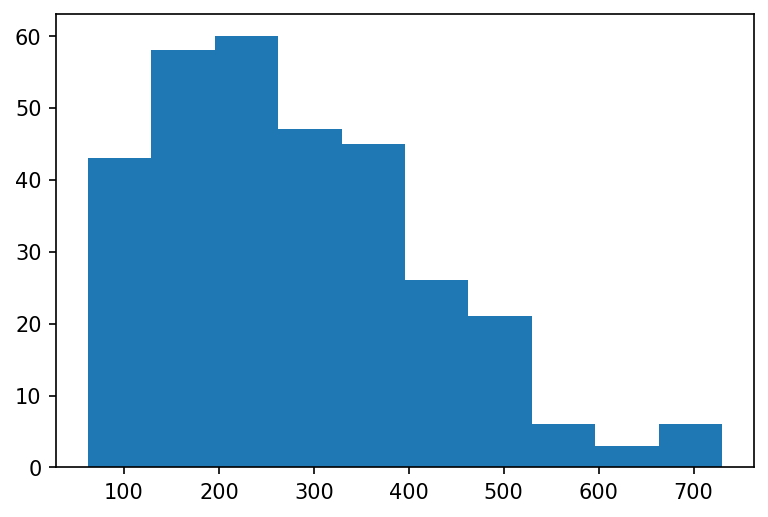

In [8]:
# 数据检查
count = []
for x in sheet_nums: 
    data_sheet = data.parse(x)  # 获取当前sheet数据
#     print(data_sheet2.shape[0])
    count.append(data_sheet.shape[0])
    
# 检查250，600区间比例
aaa,ppp = section(count,200,1000) 
print(aaa,ppp)
# ccc = require_data(data,sheet_nums,250,600)
# print(aaa,ppp,len(ccc),ccc)
# 获取样本分布数
plt.figure(dpi=150)  # 创建子图2
plt.hist(count,10)
plt.show()

总样本数： 315 
200-300区间（数量/占比）: 80 0.25396825396825395 
300-400区间（数量/占比）: 69 0.21904761904761905 
400-500区间（数量/占比）: 40 0.12698412698412698 
500-600区间（数量/占比）: 11 0.03492063492063492 
600-700区间（数量/占比）: 6 0.01904761904761905 
700及以上区间（数量/占比）: 3 0.009523809523809525


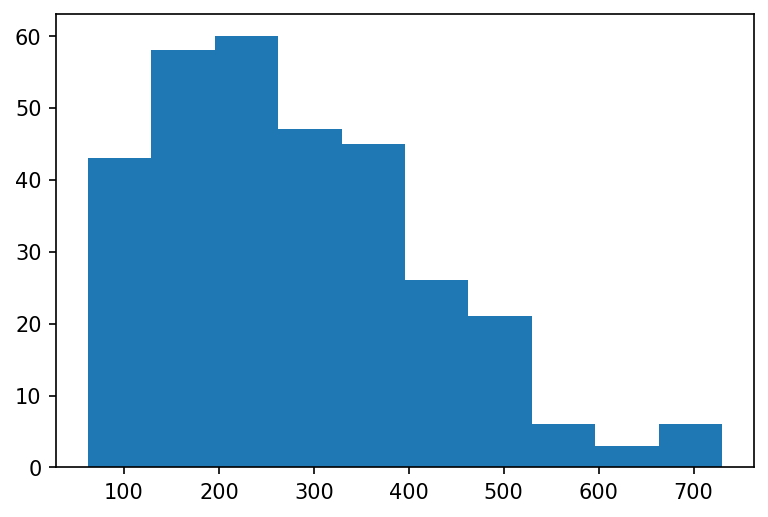

In [9]:
# 数据检查
count = []
for x in sheet_nums: 
    data_sheet = data.parse(x)  # 获取当前sheet数据
#     print(data_sheet2.shape[0])
    count.append(data_sheet.shape[0])
    
# 检查250，600区间比例
a,aa = section(count,200,300)
b,bb = section(count,300,400) 
c,cc = section(count,400,500) 
d,dd = section(count,500,600) 
f,ff = section(count,600,700) 
g,gg = section(count,700,1000) 

print('总样本数：',len(count),
      '\n200-300区间（数量/占比）:',a,aa,
      '\n300-400区间（数量/占比）:',b,bb,
      '\n400-500区间（数量/占比）:',c,cc,
      '\n500-600区间（数量/占比）:',d,dd,
      '\n600-700区间（数量/占比）:',f,ff,
      '\n700及以上区间（数量/占比）:',g,gg
      )
# ccc = require_data(data,sheet_nums,250,600)
# print(aaa,ppp,len(ccc),ccc)
# 获取样本分布数
plt.figure(dpi=150)  # 创建子图2
plt.hist(count,10)
plt.show()

In [10]:
# 按时序需求筛选样本
# sheet_req = require_data(data,sheet_nums,250,600)
# sheet_req = require_data(data,sheet_nums,300,500)
# sheet_req = require_data(data,sheet_nums,400,600)
# sheet_req = require_data(data,sheet_nums,500,700)
# sheet_req = require_data(data,sheet_nums,400,1000)
# sheet_req = require_data(data,sheet_nums,200,300)

sheet_req = require_data(data,sheet_nums,200,1000)
print(len(sheet_req),len(sheet_nums))



# old_data
# training_sheet,testing_sheet = test_split_sheet(sheet_req,Test_ratio) # 0.2
# print(len(training_sheet),len(testing_sheet),len(sheet_req),len(sheet_nums))



# # 数据检查
# count2 = []
# for x in sheet_req: 
#     data_sheet2 = data.parse(x)  # 获取当前sheet数据
# #     print(data_sheet2.shape[0])
#     count2.append(data_sheet2.shape[0])

# print('满足需求样本数：',len(count2))#,count) # 208

# ccc,fff = section(count2,250,600) # aaa,100%
# print(aaa,len(sheet_req),ccc,fff)

208 315


In [11]:
# 获取样本归一化尺度
# 'Service Meter','Working hours','Attrition rate','Category'
normalize1 = sheet_extreme(data,sheet_req,category)


# old_data
# normalize1 = sheet_extreme(data,training_sheet,category)
# normalize2 = sheet_extreme(data,testing_sheet,category)

# print(type(normalize1))

end_normalize:
 [[   0.     6854.1869]
 [   0.       24.    ]]


In [12]:
# 生成模型数据集
dataX,dataX_sm,data_wh,dataY,dataY_raw,normalize = split_data_2(data,
                                                                      sheet_req,
                                                                      normalize1,
                                                                      time_windows,
                                                                      index,
                                                                      Test_ratio,
                                                                      'classification',
                                                                      slices_nums=200)

#old_data
# dataX,dataX_sm,data_wh,dataY,dataY_raw,normalize = split_data_2(data,
#                                                                       training_sheet,
#                                                                       normalize1,
#                                                                       time_windows,
#                                                                       index,
#                                                                       Test_ratio,
#                                                                       'classification',
#                                                                       slices_nums=200)
# # 测试数据集
# dataX1,dataX_sm1,data_wh1,dataY1,dataY_raw1,normalize1 = split_data_2(data,
#                                                                       testing_sheet,
#                                                                       normalize2,
#                                                                       time_windows,
#                                                                       index,
#                                                                       Test_ratio,
#                                                                       'classification',
#                                                                       slices_nums=200)

<class 'list'> <class 'str'> 208 

样本ABF10939尺寸： (354, 2)
(354, 1) (354, 1)
当前样本WH非零个数及非零均值： 354 13.776372033898365
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
ABF10939生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (60, 140, 2) (60, 140, 1) (60, 140, 1) (60, 1) (60, 3)
样本ABF11499尺寸： (365, 2)
(365, 1) (365, 1)
当前样本WH非零个数及非零均值： 365 8.73980602739733
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
ABF11499生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (120, 140, 2) (120, 140, 1) (120, 140, 1) (120, 1) (120, 3)
样本ACE11401尺寸： (495, 

ACO01618生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (1140, 140, 2) (1140, 140, 1) (1140, 140, 1) (1140, 1) (1140, 3)
样本ACO02293尺寸： (222, 2)
(222, 1) (222, 1)
当前样本WH非零个数及非零均值： 222 6.21920135135132
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
ACO02293生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (1200, 140, 2) (1200, 140, 1) (1200, 140, 1) (1200, 1) (1200, 3)
样本ACO02417尺寸： (220, 2)
(220, 1) (220, 1)
当前样本WH非零个数及非零均值： 220 5.208399999999978
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
ACO02417生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）

样本DB400670尺寸： (468, 2)
(468, 1) (468, 1)
当前样本WH非零个数及非零均值： 468 5.059815811965809
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
DB400670生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (2220, 140, 2) (2220, 140, 1) (2220, 140, 1) (2220, 1) (2220, 3)
样本DB600555尺寸： (711, 2)
(711, 1) (711, 1)
当前样本WH非零个数及非零均值： 711 7.463692545710353
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
DB600555生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (2280, 140, 2) (2280, 140, 1) (2280, 140, 1) (2280, 1) (2280, 3)
样本EHS10060尺寸： (642, 2)
(642, 1) (642, 1)

EXM10011生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (3240, 140, 2) (3240, 140, 1) (3240, 140, 1) (3240, 1) (3240, 3)
样本GBK11743尺寸： (200, 2)
(200, 1) (200, 1)
当前样本WH非零个数及非零均值： 200 4.645323999999977
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
GBK11743生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (3300, 140, 2) (3300, 140, 1) (3300, 140, 1) (3300, 1) (3300, 3)
样本GBK11844尺寸： (235, 2)
(235, 1) (235, 1)
当前样本WH非零个数及非零均值： 235 6.608628936170184
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
GBK11844生成数据尺寸（dataX、data(sm/wh)、标签、原始标签

(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
GBK12707生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (4320, 140, 2) (4320, 140, 1) (4320, 140, 1) (4320, 1) (4320, 3)
样本GBK12712尺寸： (268, 2)
(268, 1) (268, 1)
当前样本WH非零个数及非零均值： 268 10.048830223880602
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
GBK12712生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (4380, 140, 2) (4380, 140, 1) (4380, 140, 1) (4380, 1) (4380, 3)
样本GBK12717尺寸： (288, 2)
(288, 1) (288, 1)
当前样本WH非零个数及非零均值： 288 5.706386458333301
(200, 3)
(60, 140, 2) (60, 2)
dataX Sha

(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
GBK13353生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (5400, 140, 2) (5400, 140, 1) (5400, 140, 1) (5400, 1) (5400, 3)
样本GBK13404尺寸： (406, 2)
(406, 1) (406, 1)
当前样本WH非零个数及非零均值： 406 4.575682758620666
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
GBK13404生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (5460, 140, 2) (5460, 140, 1) (5460, 140, 1) (5460, 1) (5460, 3)
样本GBK13841尺寸： (218, 2)
(218, 1) (218, 1)
当前样本WH非零个数及非零均值： 218 13.504437155963327
(200, 3)
(60, 140, 2) (60, 2)
dataX Sha

样本HEZ11052尺寸： (375, 2)
(375, 1) (375, 1)
当前样本WH非零个数及非零均值： 375 9.156998933333377
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
HEZ11052生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (7140, 140, 2) (7140, 140, 1) (7140, 140, 1) (7140, 1) (7140, 3)
样本HEZ11432尺寸： (333, 2)
(333, 1) (333, 1)
当前样本WH非零个数及非零均值： 333 3.9871348348348126
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
HEZ11432生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (7200, 140, 2) (7200, 140, 1) (7200, 140, 1) (7200, 1) (7200, 3)
样本HEZ11902尺寸： (407, 2)
(407, 1) (407, 1

样本KGX20074尺寸： (404, 2)
(404, 1) (404, 1)
当前样本WH非零个数及非零均值： 404 3.9797863861385974
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
KGX20074生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (8640, 140, 2) (8640, 140, 1) (8640, 140, 1) (8640, 1) (8640, 3)
样本KGX20100尺寸： (209, 2)
(209, 1) (209, 1)
当前样本WH非零个数及非零均值： 209 2.555489952153114
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
KGX20100生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (8700, 140, 2) (8700, 140, 1) (8700, 140, 1) (8700, 1) (8700, 3)
样本KGX20392尺寸： (258, 2)
(258, 1) (258, 1

dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
LFS10236生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (10020, 140, 2) (10020, 140, 1) (10020, 140, 1) (10020, 1) (10020, 3)
样本LFS10255尺寸： (362, 2)
(362, 1) (362, 1)
当前样本WH非零个数及非零均值： 362 8.265515193370174
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
LFS10255生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (10080, 140, 2) (10080, 140, 1) (10080, 140, 1) (10080, 1) (10080, 3)
样本LFS10686尺寸： (280, 2)
(280, 1) (280, 1)
当前样本WH非零个数及非零均值： 280 6.6331589285714045
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <

当前样本WH非零个数及非零均值： 208 2.4024961538461564
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
XGG10052生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (11340, 140, 2) (11340, 140, 1) (11340, 140, 1) (11340, 1) (11340, 3)
样本XGG10171尺寸： (470, 2)
(470, 1) (470, 1)
当前样本WH非零个数及非零均值： 470 3.196063829787219
(200, 3)
(60, 140, 2) (60, 2)
dataX Shape--  (60, 140, 2) <class 'numpy.ndarray'>
dataX_sm Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataX_wh Shape--  (60, 140, 1) <class 'numpy.ndarray'>
dataY    Shape--  (60, 1) <class 'numpy.ndarray'>
yy_raw   Shape--  (60, 3) <class 'numpy.ndarray'>
XGG10171生成数据尺寸（dataX、data(sm/wh)、标签、原始标签）： (11400, 140, 2) (11400, 140, 1) (11400, 140, 1) (11400, 1) (11400, 3)
样本YBN10707尺寸： (338, 2)
(338, 1) (338, 1)
当前样本WH非零个数及非零均值： 338 10.98777

In [13]:
print(dataY.shape,42*60)

(12480, 1) 2520


In [14]:
# 检查数据集
print(dataX.shape,166*60)
# print(dataX1.shape,42*60)

print(dataY_raw.shape)
# print(dataY_raw)
# print(dataY)
# 通过去重复获取当前样本集所用的样本个数
b = np.unique(dataY_raw[:,2])
print('测试集所用样本个数：',len(b))

(12480, 140, 2) 9960
(12480, 3)
测试集所用样本个数： 208


In [15]:
# 划分数据集
X_train,X_test, y_train, y_test =train_test_split(dataX,dataY,test_size=0.2, random_state=None)#,stratify=dataY)

# old_data
# X_train = dataX
# X_test = dataX1
# y_train = dataY
# y_test = dataY1


print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(9984, 140, 2) (2496, 140, 2) (9984, 1) (2496, 1)


In [16]:
# 检查样本标签分布
print('源数据集标签分布：')
Label_distribution(dataY)
print('\n划分后训练集标签分布：')
Label_distribution(y_train)
print('\n划分后测试集标签分布：')
Label_distribution(y_test)
# print(y_test)

源数据集标签分布：
<class 'numpy.ndarray'>
6240 6240 1.0

划分后训练集标签分布：
<class 'numpy.ndarray'>
5018 4966 1.0104712041884816

划分后测试集标签分布：
<class 'numpy.ndarray'>
1222 1274 0.9591836734693877


In [17]:
# # test
# XXX, yyy = np.arange(10).reshape((5, 2)), range(5)
# print(XXX,yyy)
# X_train00, X_test00, y_train00, y_test00 = train_test_split(XXX, yyy, test_size=0.40, random_state=0)
# print(X_train00, X_test00, y_train00, y_test00)

# 网络结构


In [18]:
# 加载模型

# def mse_2(y_true,y_pred):
#     return K.mean(K.square(y_pred-y_true)*y_true,axis=-1)
# checkpoint_directory_path = "./test1/model1_2.hdf5"#.encode('utf-8')
# print(type(checkpoint_directory_path))
# model1_2_2 = load_model(checkpoint_directory_path) # .encode().decode('unicode_escape')

# my_model = load_model("../../model/AR-16-8-adam-mse-60-2-seq.h5")
# my_model = load_model("../../model/AR-16-32-60-Adadelta-mse2-seq.h5",custom_objects={'mse_2':mse_2})
# my_model = load_model("../../model/AR-16-32-adam-mse-60-2-seq.h5")
# my_model = load_model("../../model/5/model_cat_3_124.hdf5")
# model1_2_2 = load_model("./test1/model1_2.hdf5")

In [19]:
# 数据集处理
dataX_sm0 = dataX_sm[:,[-1],:]  #####

# 单个标签数据集
X_train0_sm = X_train[:,:,[0]][:,[-1],:]
X_train0_wh = X_train[:,:,[1]][:,[-1],:]
X_test0_sm = X_test[:,:,[0]][:,[-1],:]
X_test0_wh = X_test[:,:,[1]][:,[-1],:]

print(X_train0_sm.shape,X_train0_wh.shape,X_test0_sm.shape,X_test0_wh.shape)

# 单列数据集
X_train1_sm = X_train[:,:,[0]]
X_train1_wh = X_train[:,:,[1]]
X_test1_sm = X_test[:,:,[0]]
X_test1_wh = X_test[:,:,[1]]
X_train_full = X_train[:,:,[0,1]]
X_test_full = X_test[:,:,[0,1]]

print(X_train1_sm.shape,X_train1_wh.shape,X_test1_sm.shape,X_test1_wh.shape)
print(X_train_full.shape,X_test_full.shape)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(9984, 1, 1) (9984, 1, 1) (2496, 1, 1) (2496, 1, 1)
(9984, 140, 1) (9984, 140, 1) (2496, 140, 1) (2496, 140, 1)
(9984, 140, 2) (2496, 140, 2)
(9984, 140, 2) (2496, 140, 2) (9984, 1) (2496, 1)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data_wh (InputLayer)      [(None, 140, 1)]     0                                            
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 140, 64)      16896       input_data_wh[0][0]              
__________________________________________________________________________________________________
LSTM2 (LSTM)                    (None, 140, 64)      33024       LSTM1[0][0]                      
__________________________________________________________________________________________________
LSTM3 (LSTM)      

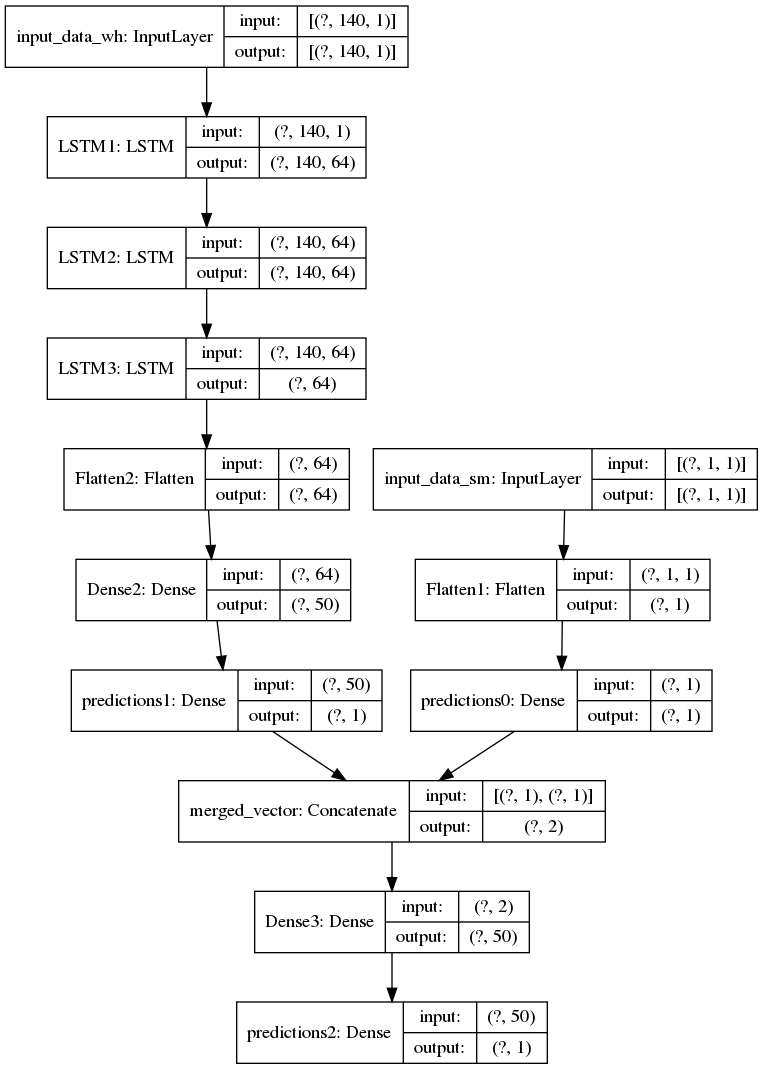

In [20]:

def build_model():
    
    # 定义输入
    input_data_sm = Input(shape=(1,1), name='input_data_sm')
    input_data_wh = Input(shape=(140,1), name='input_data_wh')
#     input_data_full = Input(shape=(140,2), name='input_data_full')

    # SM处理分支
    Flatten1 = Flatten(name="Flatten1",input_shape=(1, 1))(input_data_sm)
#     Dense1 = Dense(50, activation='sigmoid',name="Dense1",input_shape=(140, 1))(input_data_sm)
#     LR_out = Dense(1, activation='relu',name="LR_out")(Dense1)
    predictions0 = Dense(1, activation='sigmoid',name="predictions0")(Flatten1)
#     predictions0 = predictions0.reshape(-1,1)


    # fulldata处理分支
    LSTM1 = LSTM(64,input_shape=(140,1),return_sequences=True,name="LSTM1")(input_data_wh)
    LSTM2 = LSTM(64,return_sequences=True,name="LSTM2")(LSTM1)
    LSTM3 = LSTM(64,name="LSTM3")(LSTM2)

#     cnn_out = Conv1D(filters=64, kernel_size=8, activation='relu',padding='same', input_shape=(140, 1),name="cnn_out")(input_data_wh)
    Flatten2 = Flatten(name="Flatten2")(LSTM3)
    Dense2 = Dense(50, activation='sigmoid',name="Dense2")(Flatten2)
#     predictions = Dense(1, activation='sigmoid',name="predictions")(merged_vector)
    # 再在上面添加一个逻辑回归层
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Dense2)
    
#     print(predictions0.shape,predictions1.shape)
    # 合并向量：
    
    merged_vector = concatenate([predictions0, predictions1], axis=-1,name="merged_vector")
#     Flatten3 = Flatten(name="Flatten3")(merged_vector)
    Dense3 = Dense(50, activation='sigmoid',name="Dense3")(merged_vector)
#     predictions = Dense(1, activation='sigmoid',name="predictions")(merged_vector)
    # 再在上面添加一个逻辑回归层
    predictions2 = Dense(1, activation='sigmoid',name="predictions2")(Dense3)


#     inputs = [input_data_sm,input_data_full]
    inputs = [input_data_sm,input_data_wh]

    # 定义一个连接推特输入和预测的可训练的模型
    model = Model(inputs, predictions2)  ####
#     model = Model(inputs, [predictions0,predictions1,predictions2])  ####

    model.compile(optimizer='adam',  #optimizers.Adam(lr=0.001,decay=0.004),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model#,predictions0,predictions1,predictions2

model = build_model() 
# model,_,_,_ = build_model(dataX_sm0,data_wh)   

tf.keras.utils.plot_model(model,to_file='并行网络2_LR_GRU.png',show_shapes=True,show_layer_names=True)  
# pydot 相关问题： https://blog.csdn.net/qq_39418067/article/details/109262593?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522166133183816781647596666%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=166133183816781647596666&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-2-109262593-null-null.142^v42^pc_ran_alice,185^v2^tag_show&utm_term=Failed%20to%20import%20pydot.%20You%20must%20install%20pydot%20and%20graphviz%20for%20%60pydotprint%60%20to%20work.&spm=1018.2226.3001.4187

(9984, 1, 1) (9984, 1, 1) (2496, 1, 1) (2496, 1, 1)
(9984, 140, 1) (9984, 140, 1) (2496, 140, 1) (2496, 140, 1)
(9984, 140, 2) (2496, 140, 2)
Train on 9984 samples, validate on 2496 samples
Epoch 1/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6940 - acc: 0.4945
Epoch 00001: loss improved from inf to 0.69401, saving model to ./test3/model_LSTM+LR_1_1.hdf5
9984/9984 [==============================] - 21s 2ms/sample - loss: 0.6940 - acc: 0.4942 - val_loss: 0.6929 - val_acc: 0.5104
Epoch 2/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6934 - acc: 0.4991
Epoch 00002: loss improved from 0.69401 to 0.69335, saving model to ./test3/model_LSTM+LR_1_1.hdf5
9984/9984 [==============================] - 18s 2ms/sample - loss: 0.6934 - acc: 0.4997 - val_loss: 0.6931 - val_acc: 0.4932
Epoch 3/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6933 - acc: 0.5010
Epoch 00003: loss improved from 0.69335 to 0.69325, saving model to ./test3/model_

Epoch 30/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6924 - acc: 0.5141
Epoch 00030: loss did not improve from 0.69212
9984/9984 [==============================] - 18s 2ms/sample - loss: 0.6924 - acc: 0.5135 - val_loss: 0.6937 - val_acc: 0.4920
Epoch 31/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6925 - acc: 0.5241
Epoch 00031: loss did not improve from 0.69212
9984/9984 [==============================] - 18s 2ms/sample - loss: 0.6925 - acc: 0.5246 - val_loss: 0.6922 - val_acc: 0.5377
Epoch 32/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6919 - acc: 0.5289
Epoch 00032: loss improved from 0.69212 to 0.69190, saving model to ./test3/model_LSTM+LR_1_1.hdf5
9984/9984 [==============================] - 18s 2ms/sample - loss: 0.6919 - acc: 0.5285 - val_loss: 0.6918 - val_acc: 0.5377
Epoch 33/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6924 - acc: 0.5067
Epoch 00033: loss did not improve from 0.69190
99

9856/9984 [============================>.] - ETA: 0s - loss: 0.6899 - acc: 0.5330
Epoch 00058: loss improved from 0.69005 to 0.68987, saving model to ./test3/model_LSTM+LR_1_1.hdf5
9984/9984 [==============================] - 18s 2ms/sample - loss: 0.6899 - acc: 0.5336 - val_loss: 0.6903 - val_acc: 0.5248
Epoch 59/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6898 - acc: 0.5378
Epoch 00059: loss improved from 0.68987 to 0.68980, saving model to ./test3/model_LSTM+LR_1_1.hdf5
9984/9984 [==============================] - 18s 2ms/sample - loss: 0.6898 - acc: 0.5387 - val_loss: 0.6907 - val_acc: 0.5373
Epoch 60/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6896 - acc: 0.5387
Epoch 00060: loss improved from 0.68980 to 0.68966, saving model to ./test3/model_LSTM+LR_1_1.hdf5
9984/9984 [==============================] - 18s 2ms/sample - loss: 0.6897 - acc: 0.5385 - val_loss: 0.6913 - val_acc: 0.5284
Epoch 61/500
9856/9984 [============================>

Epoch 116/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6884 - acc: 0.5450
Epoch 00116: loss did not improve from 0.68819
9984/9984 [==============================] - 18s 2ms/sample - loss: 0.6884 - acc: 0.5443 - val_loss: 0.6897 - val_acc: 0.5296
Epoch 117/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6885 - acc: 0.5436
Epoch 00117: loss did not improve from 0.68819
9984/9984 [==============================] - 18s 2ms/sample - loss: 0.6884 - acc: 0.5444 - val_loss: 0.6905 - val_acc: 0.5361
Epoch 118/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6883 - acc: 0.5418
Epoch 00118: loss did not improve from 0.68819
9984/9984 [==============================] - 18s 2ms/sample - loss: 0.6883 - acc: 0.5419 - val_loss: 0.6896 - val_acc: 0.5144
Epoch 119/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6886 - acc: 0.5372
Epoch 00119: loss did not improve from 0.68819
9984/9984 [==============================] - 18s 2

Epoch 176/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6880 - acc: 0.5425
Epoch 00176: loss improved from 0.68806 to 0.68805, saving model to ./test3/model_LSTM+LR_1_1.hdf5
9984/9984 [==============================] - 12s 1ms/sample - loss: 0.6880 - acc: 0.5422 - val_loss: 0.6902 - val_acc: 0.5409
Epoch 177/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6882 - acc: 0.5444
Epoch 00177: loss did not improve from 0.68805
9984/9984 [==============================] - 12s 1ms/sample - loss: 0.6882 - acc: 0.5445 - val_loss: 0.6905 - val_acc: 0.5381
Epoch 178/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6881 - acc: 0.5452
Epoch 00178: loss did not improve from 0.68805
9984/9984 [==============================] - 12s 1ms/sample - loss: 0.6882 - acc: 0.5447 - val_loss: 0.6898 - val_acc: 0.5236
Epoch 179/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6882 - acc: 0.5396
Epoch 00179: loss improved from 0.68805 to 0.

Epoch 206/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6885 - acc: 0.5381
Epoch 00206: loss did not improve from 0.68802
9984/9984 [==============================] - 12s 1ms/sample - loss: 0.6885 - acc: 0.5382 - val_loss: 0.6899 - val_acc: 0.5321
Epoch 207/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6883 - acc: 0.5418
Epoch 00207: loss did not improve from 0.68802
9984/9984 [==============================] - 12s 1ms/sample - loss: 0.6883 - acc: 0.5421 - val_loss: 0.6899 - val_acc: 0.5357
Epoch 208/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6885 - acc: 0.5386
Epoch 00208: loss did not improve from 0.68802
9984/9984 [==============================] - 12s 1ms/sample - loss: 0.6885 - acc: 0.5387 - val_loss: 0.6899 - val_acc: 0.5329
Epoch 209/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6881 - acc: 0.5361
Epoch 00209: loss did not improve from 0.68802
9984/9984 [==============================] - 12s 1

9856/9984 [============================>.] - ETA: 0s - loss: 0.6883 - acc: 0.5410
Epoch 00266: loss did not improve from 0.68764
9984/9984 [==============================] - 12s 1ms/sample - loss: 0.6884 - acc: 0.5402 - val_loss: 0.6900 - val_acc: 0.5244
Epoch 267/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6879 - acc: 0.5405
Epoch 00267: loss did not improve from 0.68764
9984/9984 [==============================] - 12s 1ms/sample - loss: 0.6880 - acc: 0.5401 - val_loss: 0.6901 - val_acc: 0.5252
Epoch 268/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6882 - acc: 0.5401
Epoch 00268: loss did not improve from 0.68764
9984/9984 [==============================] - 12s 1ms/sample - loss: 0.6881 - acc: 0.5398 - val_loss: 0.6898 - val_acc: 0.5224
Epoch 269/500
9856/9984 [============================>.] - ETA: 0s - loss: 0.6880 - acc: 0.5433
Epoch 00269: loss did not improve from 0.68764
9984/9984 [==============================] - 12s 1ms/sample - lo

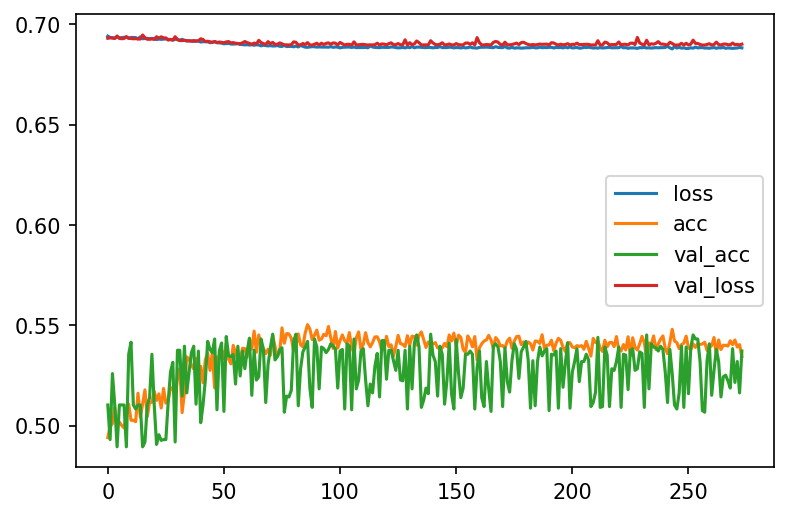

In [21]:
# fit model
# X_train_full.shape,X_test_full.shape

print(X_train0_sm.shape,X_train0_wh.shape,X_test0_sm.shape,X_test0_wh.shape)
print(X_train1_sm.shape,X_train1_wh.shape,X_test1_sm.shape,X_test1_wh.shape)
print(X_train_full.shape,X_test_full.shape)

checkpoint_save_dir='./test3/'
EarlyStop=EarlyStopping(monitor='loss'  #'val_acc',
                        ,patience=30,verbose=1, mode='auto')
checkpoint = ModelCheckpoint(os.path.join(checkpoint_save_dir, "model_LSTM+LR_1_1.hdf5"),
                             monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, EarlyStop]

start_sampling = time.time()
hist_sampling = model.fit([X_train0_sm,X_train1_wh],y_train,
#                           validation_split = 0.2, 
                          validation_data=([X_test0_sm,X_test1_wh],y_test),
                          batch_size=128, epochs=500, 
                          callbacks=callbacks_list,#,reduce_lr],
                          shuffle=True,
                          verbose=1)
end_sampling = time.time()
print('训练结束！！')
print('训练时间（分钟）：',(end_sampling-start_sampling)/60)

score_sampling = model.evaluate([X_test0_sm,X_test1_wh],y_test, batch_size=128)
print(score_sampling)
plt.figure(dpi=150)
plt.plot(hist_sampling.history['loss'], label='loss')
plt.plot(hist_sampling.history['acc'], label='acc')
plt.plot(hist_sampling.history['val_acc'], label='val_acc')
plt.plot(hist_sampling.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
# 0.004 0.018
# 

2496/2496 [==============================] - 0s 186us/sample - loss: 0.6814 - acc: 0.5737
训练集loss/acc： [0.6813940084897555, 0.57371795] 
测试集loss/acc [0.6860544245976669, 0.5572917]


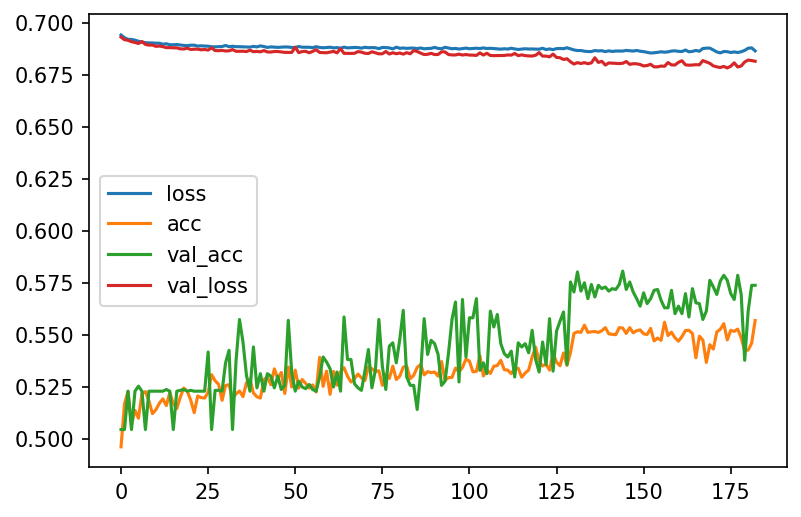

In [23]:
score_sampling = model.evaluate([X_train0_sm,X_train1_wh],y_train, batch_size=128)
score_sampling0 = model.evaluate([X_test0_sm,X_test1_wh],y_test, batch_size=128)
print('训练集loss/acc：',score_sampling0,'\n测试集loss/acc',score_sampling)

plt.figure(dpi=150)
plt.plot(hist_sampling.history['loss'], label='loss')
plt.plot(hist_sampling.history['acc'], label='acc')
plt.plot(hist_sampling.history['val_acc'], label='val_acc')
plt.plot(hist_sampling.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

[[3.1095014]] [-0.08608297]


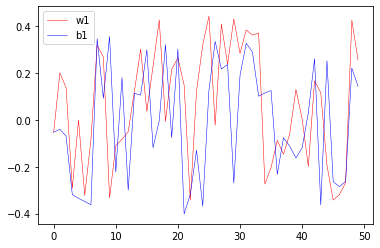

In [28]:
# 网络权重
weight_predictions0,bias_predictions0 = model.get_layer('predictions0').get_weights()
weight_predictions1,bias_predictions1 = model.get_layer('predictions1').get_weights()
weight_predictions2,bias_predictions2 = model.get_layer('predictions2').get_weights()
print(weight_predictions0,bias_predictions0)#,bias_predictions0,weight_predictions1,bias_predictions1,weight_predictions2,bias_predictions2)
# print(bias_predictions1,bias_predictions2)
plt.figure()
plt.plot(weight_predictions1,color='r',linewidth=0.5,label='w1')
plt.plot(weight_predictions2,color='b',linewidth=0.5,label='b1')

plt.legend()
plt.show()

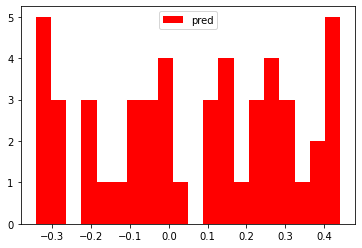

In [29]:
plt.figure()
plt.hist(weight_predictions1,20,color='r',linewidth=1,label='pred')
# plt.hist(weight_predictions2,20,color='b',linewidth=1,label='pred')
plt.legend()
plt.show()

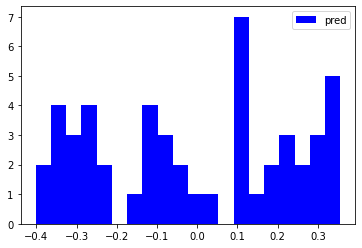

In [30]:
plt.figure()
# plt.hist(weight_predictions1,20,color='r',linewidth=1,label='pred')
plt.hist(weight_predictions2,20,color='b',linewidth=1,label='pred')
plt.legend()
plt.show()

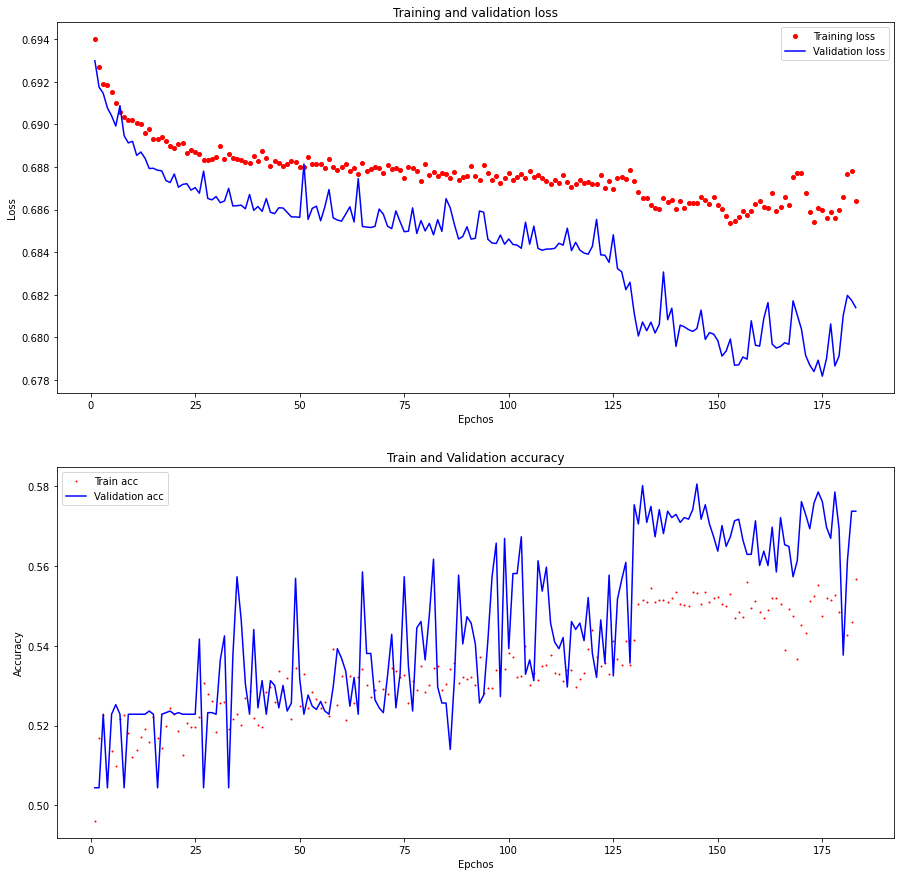

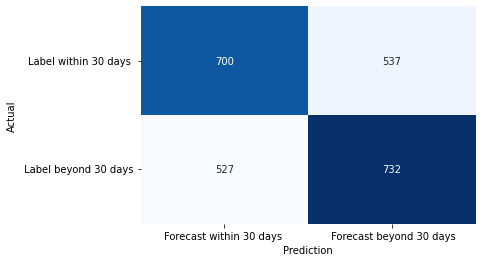

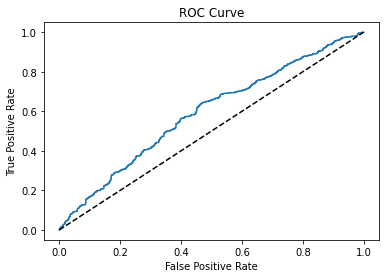

In [27]:
# 模型可视化
# loss图
plt.figure(figsize=(15,15))
ax = plt.subplot(211)
loss = hist_sampling.history['loss']
val_loss = hist_sampling.history['val_loss']
epchos = range(1, len(loss) + 1)
ax.plot(epchos, loss, 'ro', label='Training loss',markersize=4.)
ax.plot(epchos, val_loss, 'b', label='Validation loss')
ax.set_title('Training and validation loss')
ax.set_xlabel('Epchos')
ax.set_ylabel('Loss')
plt.legend()

#acc图
ax = plt.subplot(212)
# acc = hist.history['accuracy']
# val_acc = hist.history['val_accuracy']
acc = hist_sampling.history['acc']
val_acc = hist_sampling.history['val_acc']
epchos2 = range(1, len(acc) + 1)
ax.plot(epchos2, acc, 'ro', label='Train acc',markersize=1.)
ax.plot(epchos2, val_acc, 'b', label='Validation acc')
ax.set_title('Train and Validation accuracy')
ax.set_xlabel('Epchos')
ax.set_ylabel('Accuracy')
plt.legend()
# plt.savefig('model_loss_and_accuracy_cat_7.png')

import seaborn as sns
# confusion matrix
# ax1 = plt.subplot(211)
ax1=plt.figure()
y_test_predd = model.predict([X_test0_sm,X_test_full])
y_test_pred = []
for x in range(0,len(y_test_predd)):
    xx = y_test_predd[x]
    if xx > 0.51:
        y_test_pred.append([1])
    else:
        y_test_pred.append(np.round(xx)) # 四舍五入
#         prediction.append([0])

# test
c_matrix = confusion_matrix(y_test, y_test_pred)
ax1 = sns.heatmap(c_matrix,  annot=True, fmt="d",
                 xticklabels=['Forecast within 30 days ',' Forecast beyond 30 days'],
                 yticklabels=['Label within 30 days ',' Label beyond 30 days'], 
                 cbar=False, cmap='Blues')
ax1.set_xlabel("Prediction")
ax1.set_ylabel("Actual")
plt.savefig('confusion_matrix_cat_7.png')


from sklearn.metrics import roc_curve
#roc图
y_test_pred_probs = model.predict([X_test0_sm,X_test_full])
FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)
plt.figure()
plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc_cat_7.png')


In [45]:
# https://bbs.huaweicloud.com/blogs/152127
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


print(dataX.shape)
print(dataY.shape)
dataX_sampling = dataX#[0:800,:,:]
dataY_sampling = dataY#[0:800,:]

# 并行网络构建
# https://keras.io/zh/getting-started/functional-api-guide/
def build_model(data1,data2):
    # 定义输入
    input_data_sm = Input(shape=(140,1), name='input_data_sm')
    input_data_wh = Input(shape=(140,1), name='input_data_wh')
    # 定义两部分数据处理
    LR_out = Dense(64, activation='relu',input_shape=(140, 1))(input_data_sm)
    cnn_out = Conv1D(filters=64, kernel_size=8, activation='relu',padding='same', input_shape=(140, 1))(input_data_wh)

    # 然后再连接两个向量：
    merged_vector = keras.layers.concatenate([LR_out, cnn_out], axis=-1)

    # 再在上面添加一个逻辑回归层
    predictions = Dense(1, activation='sigmoid')(merged_vector)

    # 定义一个连接推特输入和预测的可训练的模型
    model = Model(inputs=[data1,data2], outputs=predictions)

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

    
    
#     model = Sequential()
#     model.add(BatchNormalization(input_shape=(140,2)))
# #     model.add(Dropout(0.3))
#     model.add(GRU(64,input_shape=(140,2),return_sequences=True
# #                  ,kernel_regularizer=regularizers.l1_l2(0.001, 0.01)
#                  ))
# #     model.add(BatchNormalization())#(model)
# #     model.add(Dropout(0.1))
#     model.add(GRU(64,return_sequences=True
# #                  ,kernel_regularizer=regularizers.l1_l2(0.001, 0.01)
#                  ))
# #     model.add(Dropout(0.1))
#     model.add(GRU(64
# #                  ,kernel_regularizer=regularizers.l1_l2(0.001, 0.01)
#                  ))
#     model.add(BatchNormalization())#(model)
# #     model.add(Dropout(0.3))
#     model.add(Dense(1, activation='sigmoid'))#'softmax'))    
#     model.compile(loss='binary_crossentropy',
#                   optimizer=optimizers.Adam(lr=0.004,
#                                             beta_1=0.9, 
#                                             beta_2=0.999, 
#                                             epsilon=None, 
#                                             decay=0.04, # https://www.cnblogs.com/wuliytTaotao/p/11101652.html
#                                             amsgrad=False), 
#                   metrics=['accuracy'])
#     model.summary()
    return model

model = build_model()   

from keras.callbacks import ReduceLROnPlateau,EarlyStopping

checkpoint_save_dir='./test1/'
EarlyStop=EarlyStopping(monitor='loss'  #'val_acc',
                        ,patience=30,verbose=1, mode='auto')
checkpoint = ModelCheckpoint(os.path.join(checkpoint_save_dir, "model_cnn1d_1_1.hdf5"),
                             monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, EarlyStop]

start_sampling = time.time()
hist_sampling = model.fit(dataX_sampling,dataY_sampling,validation_split = 0.2, 
                 batch_size=128, epochs=500, 
                 callbacks=callbacks_list,#,reduce_lr],
                 shuffle=True,
                 verbose=1)
end_sampling = time.time()
print('训练结束！！')
print('训练时间（分钟）：',(end_sampling-start_sampling)/60)

score_sampling = model.evaluate(dataX_sampling,dataY_sampling, batch_size=128)
print(score_sampling)
plt.figure(dpi=150)
plt.plot(hist_sampling.history['loss'], label='loss')
plt.plot(hist_sampling.history['acc'], label='acc')
plt.plot(hist_sampling.history['val_acc'], label='val_acc')
plt.plot(hist_sampling.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
# 0.004 0.018




(9960, 140, 2)
(9960, 1)


TypeError: build_model() missing 2 required positional arguments: 'data1' and 'data2'

In [ ]:
plt.figure(dpi=150)
plt.plot(hist_sampling.history['loss'], label='loss')
plt.plot(hist_sampling.history['acc'], label='acc')
plt.plot(hist_sampling.history['val_acc'], label='val_acc')
plt.plot(hist_sampling.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
# 小样本拟合训练2
print('小样本拟合训练!!!!')
trainX_sampling2 = trainX[0:4000,:,:]
trainY_sampling2 = trainY[0:4000,:]
testX_sampling2 = testX[0:2000,:,:]
testY_sampling2 = testY[0:2000,:]
print(trainX_sampling2.shape,trainY_sampling2.shape,testX_sampling2.shape,testY_sampling2.shape)




# 定义ReduceLROnPlateau
# reduce_lr2 = ReduceLROnPlateau(monitor='val_loss',
#                          factor=0.5,
#                          patience=5,
#                          verbose=1,
#                          mode='auto',
#                          epsilon=0.00001,
#                          cooldown=0,
#                          min_lr=0)
# ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=1)


checkpoint_save_dir='./test1/'
EarlyStop=EarlyStopping(monitor='loss'  #'val_acc',
                        ,patience=30,verbose=1, mode='auto')
checkpoint = ModelCheckpoint(os.path.join(checkpoint_save_dir, "model_GRU_1_2.hdf5"),
                             monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, EarlyStop]


start_sampling2 = time.time()
hist_sampling2 = model.fit(trainX_sampling2,trainY_sampling2
                           ,validation_data=(testX_sampling2,testY_sampling2)
                           ,batch_size=128, epochs=200
                           ,callbacks=callbacks_list
                           ,shuffle=True
                           ,verbose=1)
end_sampling2 = time.time()
print('训练时间（分钟）：',(end_sampling2-start_sampling2)/60)

score_sampling2 = model.evaluate(testX_sampling2, testY_sampling2, batch_size=128)
print(score_sampling2)
plt.figure(dpi=150)
plt.plot(hist_sampling2.history['loss'], label='loss')
plt.plot(hist_sampling2.history['acc'], label='acc')
plt.plot(hist_sampling2.history['val_acc'], label='val_acc')
plt.plot(hist_sampling2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
# 0.001 0.028

In [ ]:
plt.figure(dpi=150)
plt.plot(hist_sampling2.history['loss'], label='loss')
plt.plot(hist_sampling2.history['acc'], label='acc')
plt.plot(hist_sampling2.history['val_acc'], label='val_acc')
# plt.plot(hist_sampling2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [22]:
# 小样本拟合训练2--继续训练

print('小样本拟合训练2_2!!!!')
trainX_sampling2 = trainX[0:4000,:,:]
trainY_sampling2 = trainY[0:4000,:]
testX_sampling2 = testX[0:2000,:,:]
testY_sampling2 = testY[0:2000,:]
print(trainX_sampling2.shape,trainY_sampling2.shape,testX_sampling2.shape,testY_sampling2.shape)



checkpoint_directory_path = "./test1/model1_2.hdf5"#.encode('utf-8')
print(type(checkpoint_directory_path))
model1_2_2 = tf.keras.models.load_model(checkpoint_directory_path) # .encode().decode('unicode_escape')

checkpoint_save_dir='./test1/'
EarlyStop_1_2_2=EarlyStopping(monitor='loss'  #'val_acc',
                        ,patience=30,verbose=1, mode='auto')
checkpoint_1_2_2 = ModelCheckpoint(os.path.join(checkpoint_save_dir, "model_GRU_1_1_2.hdf5"),
                             monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list_1_2_2 = [checkpoint_1_2_2, EarlyStop_1_2_2]


start_sampling2_2 = time.time()
hist_sampling2_2 = model1_2_2.fit(trainX_sampling2,trainY_sampling2
                           ,validation_data=(testX_sampling2,testY_sampling2)
                           ,batch_size=128, epochs=200
                           ,callbacks=callbacks_list_1_2_2
                           ,shuffle=True
                           ,verbose=1)
end_sampling2_2 = time.time()
print('训练时间（分钟）：',(end_sampling2_2-start_sampling2_2)/60)

score_sampling2_2 = model1_2_2.evaluate(testX_sampling2, testY_sampling2, batch_size=128)
print(score_sampling2)
plt.figure(dpi=150)
plt.plot(hist_sampling2_2.history['loss'], label='loss')
plt.plot(hist_sampling2_2.history['acc'], label='acc')
plt.plot(hist_sampling2_2.history['val_acc'], label='val_acc')
plt.plot(hist_sampling2_2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
# 0.001 0.028
# 1000

小样本拟合训练2_2!!!!
(4000, 140, 2) (4000, 1) (2000, 140, 2) (2000, 1)
<class 'str'>
Train on 4000 samples, validate on 2000 samples
Epoch 1/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.4169 - acc: 0.7991
Epoch 00001: loss improved from inf to 0.41728, saving model to ./test1/model1_2.hdf5
4000/4000 [==============================] - 9s 2ms/sample - loss: 0.4173 - acc: 0.7993 - val_loss: 1.6930 - val_acc: 0.4450
Epoch 2/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.4188 - acc: 0.7911
Epoch 00002: loss did not improve from 0.41728
4000/4000 [==============================] - 8s 2ms/sample - loss: 0.4194 - acc: 0.7905 - val_loss: 1.6917 - val_acc: 0.4485
Epoch 3/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.4144 - acc: 0.7949
Epoch 00003: loss improved from 0.41728 to 0.41441, saving model to ./test1/model1_2.hdf5
4000/4000 [==============================] - 8s 2ms/sample - loss: 0.4144 - acc: 0.7945 - val_loss: 1.6869 - val_acc: 

Epoch 30/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.4094 - acc: 0.8014
Epoch 00030: loss did not improve from 0.40541
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.4087 - acc: 0.8020 - val_loss: 1.7355 - val_acc: 0.4395
Epoch 31/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.4073 - acc: 0.8067
Epoch 00031: loss did not improve from 0.40541
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.4082 - acc: 0.8058 - val_loss: 1.7275 - val_acc: 0.4430
Epoch 32/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.4106 - acc: 0.7956
Epoch 00032: loss did not improve from 0.40541
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.4101 - acc: 0.7958 - val_loss: 1.7293 - val_acc: 0.4425
Epoch 33/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.4077 - acc: 0.8067
Epoch 00033: loss did not improve from 0.40541
4000/4000 [==============================] - 7s 2ms/sampl

Epoch 60/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3975 - acc: 0.8160
Epoch 00060: loss did not improve from 0.39806
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3981 - acc: 0.8158 - val_loss: 1.7602 - val_acc: 0.4430
Epoch 61/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3953 - acc: 0.8150
Epoch 00061: loss improved from 0.39806 to 0.39477, saving model to ./test1/model1_2.hdf5
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3948 - acc: 0.8155 - val_loss: 1.7487 - val_acc: 0.4450
Epoch 62/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3995 - acc: 0.8125
Epoch 00062: loss did not improve from 0.39477
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.4002 - acc: 0.8123 - val_loss: 1.7561 - val_acc: 0.4435
Epoch 63/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3949 - acc: 0.8117
Epoch 00063: loss did not improve from 0.39477
4000/4000 [===

Epoch 90/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3921 - acc: 0.8150
Epoch 00090: loss did not improve from 0.38997
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3921 - acc: 0.8152 - val_loss: 1.7690 - val_acc: 0.4440
Epoch 91/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3916 - acc: 0.8158
Epoch 00091: loss did not improve from 0.38997
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3916 - acc: 0.8158 - val_loss: 1.7823 - val_acc: 0.4415
Epoch 92/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3921 - acc: 0.8148
Epoch 00092: loss did not improve from 0.38997
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3924 - acc: 0.8142 - val_loss: 1.7725 - val_acc: 0.4425
Epoch 93/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3897 - acc: 0.8153
Epoch 00093: loss did not improve from 0.38997
4000/4000 [==============================] - 7s 2ms/sampl

Epoch 120/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3840 - acc: 0.8183
Epoch 00120: loss did not improve from 0.38091
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3830 - acc: 0.8192 - val_loss: 1.8192 - val_acc: 0.4430
Epoch 121/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3806 - acc: 0.8236
Epoch 00121: loss did not improve from 0.38091
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3824 - acc: 0.8227 - val_loss: 1.8112 - val_acc: 0.4430
Epoch 122/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3850 - acc: 0.8211
Epoch 00122: loss did not improve from 0.38091
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3841 - acc: 0.8215 - val_loss: 1.7943 - val_acc: 0.4470
Epoch 123/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3844 - acc: 0.8196
Epoch 00123: loss did not improve from 0.38091
4000/4000 [==============================] - 7s 2ms/s

Epoch 150/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3731 - acc: 0.8266
Epoch 00150: loss improved from 0.37547 to 0.37381, saving model to ./test1/model1_2.hdf5
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3738 - acc: 0.8260 - val_loss: 1.8177 - val_acc: 0.4460
Epoch 151/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3738 - acc: 0.8254
Epoch 00151: loss improved from 0.37381 to 0.37357, saving model to ./test1/model1_2.hdf5
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3736 - acc: 0.8255 - val_loss: 1.8234 - val_acc: 0.4455
Epoch 152/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3765 - acc: 0.8261
Epoch 00152: loss did not improve from 0.37357
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3760 - acc: 0.8260 - val_loss: 1.8306 - val_acc: 0.4455
Epoch 153/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3770 - acc: 0.8261
Epoch 00153: l

Epoch 180/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3723 - acc: 0.8279
Epoch 00180: loss did not improve from 0.37004
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3731 - acc: 0.8275 - val_loss: 1.8444 - val_acc: 0.4435
Epoch 181/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3680 - acc: 0.8306
Epoch 00181: loss improved from 0.37004 to 0.36862, saving model to ./test1/model1_2.hdf5
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3686 - acc: 0.8303 - val_loss: 1.8472 - val_acc: 0.4435
Epoch 182/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3677 - acc: 0.8324
Epoch 00182: loss did not improve from 0.36862
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3691 - acc: 0.8317 - val_loss: 1.8594 - val_acc: 0.4425
Epoch 183/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3745 - acc: 0.8236
Epoch 00183: loss did not improve from 0.36862
4000/4000 

Epoch 210/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3670 - acc: 0.8296
Epoch 00210: loss did not improve from 0.36542
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3664 - acc: 0.8300 - val_loss: 1.8642 - val_acc: 0.4465
Epoch 211/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3667 - acc: 0.8309
Epoch 00211: loss did not improve from 0.36542
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3677 - acc: 0.8303 - val_loss: 1.8718 - val_acc: 0.4445
Epoch 212/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3673 - acc: 0.8284
Epoch 00212: loss did not improve from 0.36542
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3676 - acc: 0.8285 - val_loss: 1.8711 - val_acc: 0.4450
Epoch 213/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3690 - acc: 0.8241
Epoch 00213: loss did not improve from 0.36542
4000/4000 [==============================] - 7s 2ms/s

Epoch 240/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3630 - acc: 0.8377
Epoch 00240: loss did not improve from 0.35921
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3630 - acc: 0.8375 - val_loss: 1.9073 - val_acc: 0.4415
Epoch 241/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3628 - acc: 0.8364
Epoch 00241: loss did not improve from 0.35921
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3629 - acc: 0.8363 - val_loss: 1.8866 - val_acc: 0.4490
Epoch 242/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3607 - acc: 0.8317
Epoch 00242: loss did not improve from 0.35921
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3605 - acc: 0.8317 - val_loss: 1.9038 - val_acc: 0.4435
Epoch 243/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3602 - acc: 0.8369
Epoch 00243: loss did not improve from 0.35921
4000/4000 [==============================] - 7s 2ms/s

Epoch 270/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3592 - acc: 0.8367
Epoch 00270: loss did not improve from 0.35513
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3588 - acc: 0.8372 - val_loss: 1.9103 - val_acc: 0.4435
Epoch 271/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3589 - acc: 0.8372
Epoch 00271: loss did not improve from 0.35513
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3589 - acc: 0.8367 - val_loss: 1.9057 - val_acc: 0.4440
Epoch 272/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3583 - acc: 0.8390
Epoch 00272: loss did not improve from 0.35513
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3584 - acc: 0.8388 - val_loss: 1.8934 - val_acc: 0.4490
Epoch 273/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3558 - acc: 0.8440
Epoch 00273: loss did not improve from 0.35513
4000/4000 [==============================] - 7s 2ms/s

Epoch 330/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3493 - acc: 0.8455
Epoch 00330: loss did not improve from 0.34692
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3497 - acc: 0.8455 - val_loss: 1.9446 - val_acc: 0.4365
Epoch 331/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3507 - acc: 0.8427
Epoch 00331: loss did not improve from 0.34692
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3511 - acc: 0.8422 - val_loss: 1.9240 - val_acc: 0.4385
Epoch 332/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3528 - acc: 0.8372
Epoch 00332: loss did not improve from 0.34692
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3531 - acc: 0.8367 - val_loss: 1.9114 - val_acc: 0.4445
Epoch 333/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3541 - acc: 0.8369
Epoch 00333: loss did not improve from 0.34692
4000/4000 [==============================] - 7s 2ms/s

Epoch 360/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3412 - acc: 0.8495
Epoch 00360: loss improved from 0.34340 to 0.34227, saving model to ./test1/model1_2.hdf5
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3423 - acc: 0.8487 - val_loss: 1.9426 - val_acc: 0.4400
Epoch 361/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3483 - acc: 0.8402
Epoch 00361: loss did not improve from 0.34227
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3489 - acc: 0.8393 - val_loss: 1.9395 - val_acc: 0.4385
Epoch 362/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3456 - acc: 0.8465
Epoch 00362: loss did not improve from 0.34227
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3465 - acc: 0.8460 - val_loss: 1.9632 - val_acc: 0.4350
Epoch 363/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3467 - acc: 0.8455
Epoch 00363: loss did not improve from 0.34227
4000/4000 

3968/4000 [============================>.] - ETA: 0s - loss: 0.3358 - acc: 0.8561
Epoch 00420: loss improved from 0.33628 to 0.33584, saving model to ./test1/model1_2.hdf5
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3358 - acc: 0.8553 - val_loss: 1.9874 - val_acc: 0.4315
Epoch 421/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3370 - acc: 0.8503
Epoch 00421: loss did not improve from 0.33584
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3386 - acc: 0.8495 - val_loss: 1.9969 - val_acc: 0.4310
Epoch 422/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3398 - acc: 0.8475
Epoch 00422: loss did not improve from 0.33584
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3403 - acc: 0.8470 - val_loss: 1.9773 - val_acc: 0.4345
Epoch 423/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3371 - acc: 0.8511
Epoch 00423: loss did not improve from 0.33584
4000/4000 [=============

Epoch 480/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3317 - acc: 0.8531
Epoch 00480: loss did not improve from 0.32809
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3321 - acc: 0.8530 - val_loss: 1.9943 - val_acc: 0.4320
Epoch 481/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3302 - acc: 0.8566
Epoch 00481: loss did not improve from 0.32809
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3303 - acc: 0.8568 - val_loss: 1.9881 - val_acc: 0.4335
Epoch 482/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3300 - acc: 0.8564
Epoch 00482: loss did not improve from 0.32809
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.3304 - acc: 0.8560 - val_loss: 2.0025 - val_acc: 0.4300
Epoch 483/500
3968/4000 [============================>.] - ETA: 0s - loss: 0.3279 - acc: 0.8586
Epoch 00483: loss improved from 0.32809 to 0.32747, saving model to ./test1/model1_2.hdf5
4000/4000 

NameError: name 'score_sampling2' is not defined

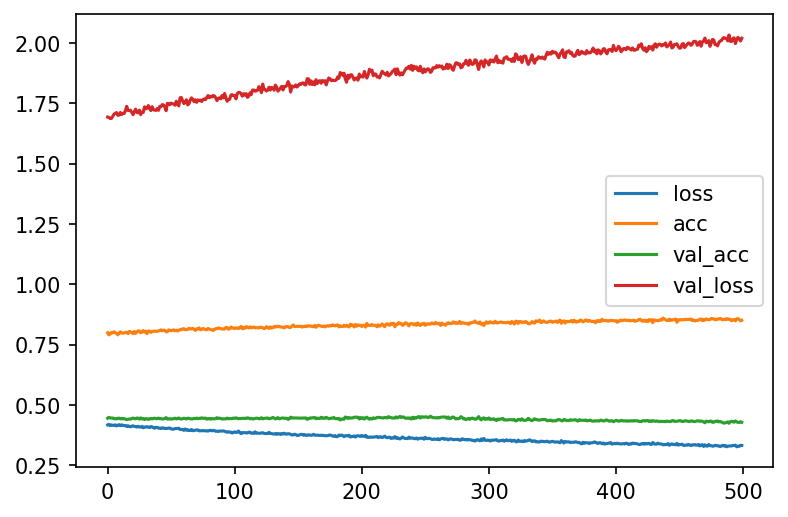

In [26]:
plt.figure(dpi=150)
plt.plot(hist_sampling2_2.history['loss'], label='loss')
plt.plot(hist_sampling2_2.history['acc'], label='acc')
plt.plot(hist_sampling2_2.history['val_acc'], label='val_acc')
plt.plot(hist_sampling2_2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(9960, 140, 1) (9960, 1) (2520, 140, 1) (2520, 1)
Train on 9960 samples, validate on 2520 samples
Epoch 1/200
9856/9960 [============================>.] - ETA: 0s - loss: 0.7717 - acc: 0.5338
Epoch 00001: loss improved from inf to 0.77081, saving model to ./test1/model_GRU_1_1_3.hdf5
9960/9960 [==============================] - 26s 3ms/sample - loss: 0.7708 - acc: 0.5332 - val_loss: 0.9296 - val_acc: 0.5786
Epoch 2/200
9856/9960 [============================>.] - ETA: 0s - loss: 0.7180 - acc: 0.5326
Epoch 00002: loss improved from 0.77081 to 0.71722, saving model to ./test1/model_GRU_1_1_3.hdf5
9960/9960 [==============================] - 49s 5ms/sample - loss: 0.7172 - acc: 0.5329 - val_loss: 0.7998 - val_acc: 0.5480
Epoch 3/200
9856/9960 [============================>.] - ETA: 0s - loss: 0.7052 - acc: 0.5464
Epoch 00003: loss improved from 0.71722 to 0.70445, saving model to ./test1/model_GRU_1_1_3.hdf5
9960/9960 [==============================] - 48s 5ms/sample - loss: 0.7044 - acc:

Epoch 28/200
9856/9960 [============================>.] - ETA: 0s - loss: 0.6758 - acc: 0.5730
Epoch 00028: loss did not improve from 0.67487
9960/9960 [==============================] - 49s 5ms/sample - loss: 0.6759 - acc: 0.5725 - val_loss: 0.6827 - val_acc: 0.5524
Epoch 29/200
9856/9960 [============================>.] - ETA: 0s - loss: 0.6755 - acc: 0.5800
Epoch 00029: loss did not improve from 0.67487
9960/9960 [==============================] - 50s 5ms/sample - loss: 0.6754 - acc: 0.5798 - val_loss: 0.6815 - val_acc: 0.5464
Epoch 30/200
9856/9960 [============================>.] - ETA: 0s - loss: 0.6759 - acc: 0.5783
Epoch 00030: loss did not improve from 0.67487
9960/9960 [==============================] - 50s 5ms/sample - loss: 0.6760 - acc: 0.5778 - val_loss: 0.6830 - val_acc: 0.5540
Epoch 31/200
9856/9960 [============================>.] - ETA: 0s - loss: 0.6760 - acc: 0.5741
Epoch 00031: loss did not improve from 0.67487
9960/9960 [==============================] - 50s 5ms/s

Epoch 00057: early stopping
训练时间（分钟）： 49.52926093737285
2520/2520 [==============================] - 4s 1ms/sample - loss: 0.6972 - acc: 0.5115
[0.6972319951133122, 0.5115079]


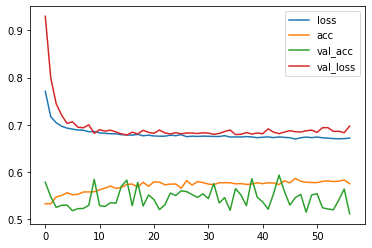

In [45]:
# 全样本训练
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

checkpoint_save_dir='./test1/'
EarlyStop=EarlyStopping(monitor='loss'  #'val_acc',
                        ,patience=10,verbose=1, mode='auto')
checkpoint = ModelCheckpoint(os.path.join(checkpoint_save_dir, "model_GRU_1_1_3.hdf5"),
                             monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, EarlyStop]


start = time.time()
hist = model.fit(trainX,trainY,validation_data=(testX,testY)
                 ,batch_size=128, epochs=200
                 ,callbacks=callbacks_list
                 ,shuffle=True
                 ,verbose=1)
end = time.time()
print('训练时间（分钟）：',(end-start)/60)

score = model.evaluate(testX, testY, batch_size=128)
print(score)

plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


# train loss 不断下降，test loss不断下降，说明网络仍在学习;

# train loss 不断下降，test loss趋于不变，说明网络过拟合;

# train loss 趋于不变，test loss不断下降，说明数据集100%有问题;

# train loss 趋于不变，test loss趋于不变，说明学习遇到瓶颈，需要减小学习率或批量数目;

# train loss 不断上升，test loss不断上升，说明网络结构设计不当，训练超参数设置不当，数据集经过清洗等问题。

# https://www.cnblogs.com/kamekin/p/10163743.html
# https://www.zhihu.com/question/41631631
# https://blog.csdn.net/WJ_MeiMei/article/details/86551738?spm=1001.2101.3001.6650.5&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-5-86551738-blog-122043591.pc_relevant_multi_platform_whitelistv3&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7EBlogCommendFromBaidu%7ERate-5-86551738-blog-122043591.pc_relevant_multi_platform_whitelistv3

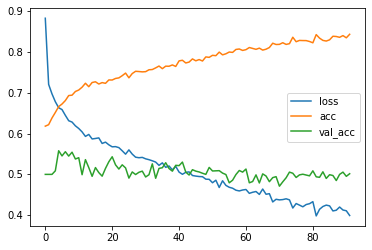

In [30]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['val_acc'], label='val_acc')
# plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [26]:
# model.save("../../model/Cat-test1.h5")


In [22]:
# 获取模型中间参数
def get_layer_output(model, x, index=-1):
    """
    get the computing result output of any layer you want, default the last layer.
    :param model: primary model
    :param x: input of primary model( x of model.predict([x])[0])
    :param index: index of target layer, i.e., layer[23]
    :return: result
    """
    layer = K.function([model.input], [model.layers[index].output])
    return layer([x])#[0]

# my_model = load_model("../../model/Cat-32-64-adam-bce-seq.h5")
my_model2 = model
input_x = testX[200]#trainX[800]
input_x = np.reshape(input_x, (-1, 140, 2))
# print(input_x)
layer0 = get_layer_output(my_model2, input_x, index=0)
layer1 = get_layer_output(my_model2, input_x, index=1)
layer2 = get_layer_output(my_model2, input_x, index=2)
layer3 = get_layer_output(my_model2, input_x, index=3)
layer4 = get_layer_output(my_model2, input_x, index=4)
print('网络第一层输出：',type(layer0),layer0[0].shape)
print('网络第二层输出：',type(layer1),layer1[0].shape,layer1[0])
print('网络第三层输出：',type(layer2),layer2[0].shape,layer2[0])
print('网络第四层输出：',type(layer3),layer3[0].shape,layer3[0],'\n')
print(type(layer4),layer4[0].shape,layer4[0])
print(testY[1])

pree=model.predict(testX)
# print(y_test_pred,'\n',testY)

网络第一层输出： <class 'list'> (1, 140, 50)
网络第二层输出： <class 'list'> (1, 50) [[1.34631857e-01 0.00000000e+00 0.00000000e+00 1.34372138e-04
  0.00000000e+00 6.82093054e-02 4.12759744e-02 0.00000000e+00
  9.78251770e-02 0.00000000e+00 7.71695301e-02 1.98580511e-02
  8.82102028e-02 3.33644450e-02 6.97984768e-04 6.63018674e-02
  1.15719438e-02 9.05754194e-02 0.00000000e+00 0.00000000e+00
  6.38512820e-02 1.17437854e-01 0.00000000e+00 4.39574905e-02
  0.00000000e+00 1.06187405e-14 4.38571125e-02 0.00000000e+00
  4.99842167e-02 0.00000000e+00 6.70364829e-15 2.70063635e-02
  0.00000000e+00 0.00000000e+00 2.94062067e-02 0.00000000e+00
  5.18149803e-12 2.07328625e-07 3.11842598e-02 1.33109972e-01
  7.57436152e-04 9.50169861e-02 1.62598848e-01 0.00000000e+00
  4.45795618e-02 1.45040863e-11 1.01041898e-01 2.86589563e-02
  1.18518732e-01 4.26340401e-02]]
网络第三层输出： <class 'list'> (1, 50) [[-1.8644595e-01 -5.1545762e-03 -2.8933130e-02 -1.3286529e-01
   2.0817569e-02 -1.5803432e-01  9.3673587e-02  2.0662328e-

In [22]:
# 声明回归模型
grid_mod = KerasClassifier(build_fn=build_model,verbose=1)#,validation_data=(testX,testY))
                                                # https://stackoverflow.com/questions/47902295/what-is-the-use-of-verbose-in-keras-while-validating-the-model
                                                # verbose=1将向您显示一个像这样的动画进度条
# GridSearchCV查找的参数列表
parameters = {'batch_size' : (32,16), 'epochs' : (64,128),  'optimizer' : ('adam','Adadelta',)}
grid_search  = GridSearchCV(estimator = grid_mod,
                            param_grid = parameters,
                            cv = 2)
# 声明回调函数模块
# 记录损失
history = LossHistory()  # 这里是使用自定义的Callback回调函数，当然本身fit函数也会返回一个history可供使用
   
# 记录检查点
model_path = './model/5/'
weight_file = "model_cat_3_{epoch:02d}.hdf5"#-{val_acc:.2f}
checkpoint_path = os.path.join(model_path, weight_file)
checkpointer = ModelCheckpoint(checkpoint_path, monitor='loss',verbose=1,save_best_only=True)

# fit模型
log_dir=os.path.join(model_path,'logs')
grid_search = grid_search.fit(trainX,trainY,validation_data=(testX,testY),
                              callbacks=[#callbacks.History(),
                              TensorBoard(log_dir, histogram_freq=1, batch_size=16, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch'),
                              history,checkpointer,])
# 10:45--13:10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 140, 50)           10600     
_________________________________________________________________
dropout (Dropout)            (None, 140, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/64
156/156 [==============================] - 10s 59ms/step - loss: 27.9666 - accuracy: 0.4983 - val_loss: 0.6

156/156 [==============================] - 8s 54ms/step - loss: 0.6934 - accuracy: 0.5141 - val_loss: 0.6903 - val_accuracy: 0.5679

Epoch 00006: loss did not improve from 0.68511
Epoch 7/64
156/156 [==============================] - 8s 54ms/step - loss: 0.6937 - accuracy: 0.5173 - val_loss: 0.6900 - val_accuracy: 0.5667

Epoch 00007: loss did not improve from 0.68511
Epoch 8/64
156/156 [==============================] - 8s 54ms/step - loss: 0.6912 - accuracy: 0.5373 - val_loss: 0.6899 - val_accuracy: 0.5321

Epoch 00008: loss did not improve from 0.68511
Epoch 9/64
156/156 [==============================] - 8s 54ms/step - loss: 0.6914 - accuracy: 0.5329 - val_loss: 0.6899 - val_accuracy: 0.5286

Epoch 00009: loss did not improve from 0.68511
Epoch 10/64
156/156 [==============================] - 8s 54ms/step - loss: 0.6930 - accuracy: 0.5077 - val_loss: 0.6899 - val_accuracy: 0.5353

Epoch 00010: loss did not improve from 0.68511
Epoch 11/64
156/156 [==============================] - 


Epoch 00048: loss did not improve from 0.68511
Epoch 49/64
156/156 [==============================] - 8s 54ms/step - loss: 0.6914 - accuracy: 0.5297 - val_loss: 0.6904 - val_accuracy: 0.5508

Epoch 00049: loss did not improve from 0.68511
Epoch 50/64
156/156 [==============================] - 8s 54ms/step - loss: 0.6914 - accuracy: 0.5152 - val_loss: 0.6903 - val_accuracy: 0.5405

Epoch 00050: loss did not improve from 0.68511
Epoch 51/64
156/156 [==============================] - 8s 54ms/step - loss: 0.6923 - accuracy: 0.5211 - val_loss: 0.6903 - val_accuracy: 0.5385

Epoch 00051: loss did not improve from 0.68511
Epoch 52/64
156/156 [==============================] - 9s 55ms/step - loss: 0.6912 - accuracy: 0.5336 - val_loss: 0.6903 - val_accuracy: 0.5373

Epoch 00052: loss did not improve from 0.68511
Epoch 53/64
156/156 [==============================] - 9s 55ms/step - loss: 0.6926 - accuracy: 0.5216 - val_loss: 0.6903 - val_accuracy: 0.5437

Epoch 00053: loss did not improve from 


Epoch 00062: loss did not improve from 0.68511
Epoch 63/64
156/156 [==============================] - 9s 55ms/step - loss: 0.6927 - accuracy: 0.5002 - val_loss: 0.6925 - val_accuracy: 0.5131

Epoch 00063: loss did not improve from 0.68511
Epoch 64/64
156/156 [==============================] - 9s 55ms/step - loss: 0.6929 - accuracy: 0.4957 - val_loss: 0.6925 - val_accuracy: 0.5131

Epoch 00064: loss did not improve from 0.68511
156/156 [==============================] - 2s 13ms/step - loss: 0.6927 - accuracy: 0.5000
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 140, 50)           10600     
_________________________________________________________________
dropout_6 (Dropout)          (None, 140, 50)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200


Epoch 00005: loss did not improve from 0.68511
Epoch 6/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6928 - accuracy: 0.5031 - val_loss: 0.6925 - val_accuracy: 0.5000

Epoch 00006: loss did not improve from 0.68511
Epoch 7/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6927 - accuracy: 0.5093 - val_loss: 0.6923 - val_accuracy: 0.5135

Epoch 00007: loss did not improve from 0.68511
Epoch 8/128
156/156 [==============================] - 8s 48ms/step - loss: 12.2173 - accuracy: 0.5164 - val_loss: 0.6924 - val_accuracy: 0.5167

Epoch 00008: loss did not improve from 0.68511
Epoch 9/128
156/156 [==============================] - 7s 47ms/step - loss: 0.6923 - accuracy: 0.5272 - val_loss: 0.6923 - val_accuracy: 0.5468

Epoch 00009: loss did not improve from 0.68511
Epoch 10/128
156/156 [==============================] - 7s 47ms/step - loss: 0.6918 - accuracy: 0.5319 - val_loss: 0.6927 - val_accuracy: 0.5103

Epoch 00010: loss did not improve fro

156/156 [==============================] - 7s 48ms/step - loss: 0.6899 - accuracy: 0.5365 - val_loss: 0.6913 - val_accuracy: 0.5627

Epoch 00090: loss did not improve from 0.68511
Epoch 91/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6880 - accuracy: 0.5371 - val_loss: 0.6936 - val_accuracy: 0.5548

Epoch 00091: loss did not improve from 0.68511
Epoch 92/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6911 - accuracy: 0.5263 - val_loss: 0.6915 - val_accuracy: 0.5575

Epoch 00092: loss did not improve from 0.68511
Epoch 93/128
156/156 [==============================] - 8s 48ms/step - loss: 0.6883 - accuracy: 0.5348 - val_loss: 0.6926 - val_accuracy: 0.5500

Epoch 00093: loss did not improve from 0.68511
Epoch 94/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6881 - accuracy: 0.5520 - val_loss: 0.6913 - val_accuracy: 0.5417

Epoch 00094: loss did not improve from 0.68511
Epoch 95/128
156/156 [==========================

_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/128
156/156 [==============================] - 9s 51ms/step - loss: 0.6928 - accuracy: 0.5257 - val_loss: 0.6901 - val_accuracy: 0.5734

Epoch 00001: loss did not improve from 0.68465
Epoch 2/128
156/156 [==============================] - 7s 47ms/step - loss: 0.6914 - accuracy: 0.5293 - val_loss: 0.6894 - val_accuracy: 0.5306

Epoch 00002: loss did not improve from 0.68465
Epoch 3/128
156/156 [==============================] - 8s 48ms/step - loss: 0.6883 - accuracy: 0.5581 - val_loss: 0.6904 - val_accuracy: 0.5218

Epoch 00003: loss did not improve from 0.68465
Epoch 4/128
156/156 [===


Epoch 00081: loss did not improve from 0.68465
Epoch 82/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6932 - accuracy: 0.5167 - val_loss: 0.6929 - val_accuracy: 0.5381

Epoch 00082: loss did not improve from 0.68465
Epoch 83/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6933 - accuracy: 0.4992 - val_loss: 0.6929 - val_accuracy: 0.5460

Epoch 00083: loss did not improve from 0.68465
Epoch 84/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6929 - accuracy: 0.5196 - val_loss: 0.6929 - val_accuracy: 0.5448

Epoch 00084: loss did not improve from 0.68465
Epoch 85/128
156/156 [==============================] - 7s 47ms/step - loss: 0.6927 - accuracy: 0.5230 - val_loss: 0.6929 - val_accuracy: 0.5377

Epoch 00085: loss did not improve from 0.68465
Epoch 86/128
156/156 [==============================] - 7s 47ms/step - loss: 0.6929 - accuracy: 0.5058 - val_loss: 0.6929 - val_accuracy: 0.5325

Epoch 00086: loss did not improve 

156/156 [==============================] - 7s 48ms/step - loss: 0.6934 - accuracy: 0.4942 - val_loss: 0.6932 - val_accuracy: 0.4929

Epoch 00031: loss did not improve from 0.68465
Epoch 32/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6936 - accuracy: 0.4885 - val_loss: 0.6932 - val_accuracy: 0.4929

Epoch 00032: loss did not improve from 0.68465
Epoch 33/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6937 - accuracy: 0.4843 - val_loss: 0.6932 - val_accuracy: 0.4929

Epoch 00033: loss did not improve from 0.68465
Epoch 34/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.4929

Epoch 00034: loss did not improve from 0.68465
Epoch 35/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6933 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.4929

Epoch 00035: loss did not improve from 0.68465
Epoch 36/128
156/156 [==========================


Epoch 00073: loss did not improve from 0.68465
Epoch 74/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.4937

Epoch 00074: loss did not improve from 0.68465
Epoch 75/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6933 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.4929

Epoch 00075: loss did not improve from 0.68465
Epoch 76/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6933 - accuracy: 0.4891 - val_loss: 0.6931 - val_accuracy: 0.4960

Epoch 00076: loss did not improve from 0.68465
Epoch 77/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6928 - accuracy: 0.5060 - val_loss: 0.6931 - val_accuracy: 0.4940

Epoch 00077: loss did not improve from 0.68465
Epoch 78/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6932 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.4944

Epoch 00078: loss did not improve 

156/156 [==============================] - 7s 48ms/step - loss: 0.6935 - accuracy: 0.4768 - val_loss: 0.6935 - val_accuracy: 0.4456

Epoch 00023: loss did not improve from 0.68465
Epoch 24/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6935 - accuracy: 0.4948 - val_loss: 0.6935 - val_accuracy: 0.4472

Epoch 00024: loss did not improve from 0.68465
Epoch 25/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6936 - accuracy: 0.4719 - val_loss: 0.6935 - val_accuracy: 0.4480

Epoch 00025: loss did not improve from 0.68465
Epoch 26/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6936 - accuracy: 0.4860 - val_loss: 0.6935 - val_accuracy: 0.4484

Epoch 00026: loss did not improve from 0.68465
Epoch 27/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6934 - accuracy: 0.4950 - val_loss: 0.6935 - val_accuracy: 0.4488

Epoch 00027: loss did not improve from 0.68465
Epoch 28/128
156/156 [==========================


Epoch 00065: loss did not improve from 0.68465
Epoch 66/128
156/156 [==============================] - 7s 47ms/step - loss: 0.6934 - accuracy: 0.4835 - val_loss: 0.6933 - val_accuracy: 0.4750

Epoch 00066: loss did not improve from 0.68465
Epoch 67/128
156/156 [==============================] - 7s 47ms/step - loss: 0.6933 - accuracy: 0.4889 - val_loss: 0.6933 - val_accuracy: 0.4750

Epoch 00067: loss did not improve from 0.68465
Epoch 68/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6935 - accuracy: 0.4686 - val_loss: 0.6933 - val_accuracy: 0.4766

Epoch 00068: loss did not improve from 0.68465
Epoch 69/128
156/156 [==============================] - 7s 47ms/step - loss: 0.6932 - accuracy: 0.5059 - val_loss: 0.6933 - val_accuracy: 0.4794

Epoch 00069: loss did not improve from 0.68465
Epoch 70/128
156/156 [==============================] - 7s 48ms/step - loss: 0.6929 - accuracy: 0.5115 - val_loss: 0.6933 - val_accuracy: 0.4806

Epoch 00070: loss did not improve 

312/312 [==============================] - 13s 42ms/step - loss: 0.6958 - accuracy: 0.5253 - val_loss: 0.6925 - val_accuracy: 0.5337

Epoch 00015: loss did not improve from 0.68465
Epoch 16/64
312/312 [==============================] - 13s 42ms/step - loss: 0.6926 - accuracy: 0.4941 - val_loss: 0.6924 - val_accuracy: 0.5544

Epoch 00016: loss did not improve from 0.68465
Epoch 17/64
312/312 [==============================] - 13s 42ms/step - loss: 0.6912 - accuracy: 0.5350 - val_loss: 0.6920 - val_accuracy: 0.5433

Epoch 00017: loss did not improve from 0.68465
Epoch 18/64
312/312 [==============================] - 13s 42ms/step - loss: 0.6904 - accuracy: 0.5418 - val_loss: 0.6915 - val_accuracy: 0.5357

Epoch 00018: loss did not improve from 0.68465
Epoch 19/64
312/312 [==============================] - 13s 42ms/step - loss: 0.6877 - accuracy: 0.5434 - val_loss: 0.6908 - val_accuracy: 0.5504

Epoch 00019: loss did not improve from 0.68465
Epoch 20/64
312/312 [==========================

/home/cxking/.miniconda3/envs/torch180/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


InvalidArgumentError: Nan in summary histogram for: lstm_18/lstm_cell_18/kernel_0 [Op:WriteHistogramSummary]

In [24]:
# 最优模型参数模型参数
# print('最优模型参数：',grid_search.best_params_)
# 最佳分数
# print('最佳得分',grid_search.best_score_)

# 存储最佳模型
my_model=grid_search.best_estimator_.model
# 打印网络结构
print('当前网络结构：',my_model.summary())

# import matplotlib.pyplot as plt
# plt.plot(my_model.history['loss'], label='loss')
# plt.plot(my_model.history['accuracy'], label='acc')
# plt.plot(my_model.history['val_accuracy'], label='val_acc')
# plt.legend()
# plt.show()

    
#绘制训练的acc-loss曲线
history.loss_plot('epoch') # 每一个epoch展示一次
# https://blog.csdn.net/qq_27825451/article/details/93377801?spm=1001.2101.3001.6650.2&utm_medium=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-93377801-blog-84571658.nonecase&depth_1-utm_source=distribute.pc_relevant.none-task-blog-2%7Edefault%7ECTRLIST%7ERate-2-93377801-blog-84571658.nonecase&utm_relevant_index=3


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

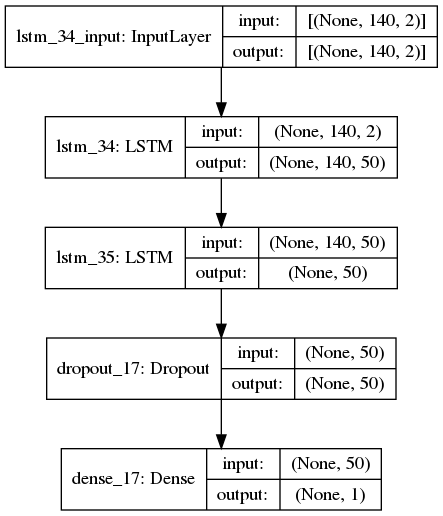

In [20]:

# 展示网络结构图并保存
tf.keras.utils.plot_model(my_model,to_file='model_cat_3.png',show_shapes=True,show_layer_names=True)

{'loss': [0.7536372542381287, 0.6948819160461426, 0.6960766315460205, 0.6937052607536316, 0.6953586339950562, 0.6919061541557312, 0.6900885105133057, 0.68935227394104, 0.6895175576210022, 0.6878776550292969, 0.6880475878715515, 0.6907786726951599, 0.6932742595672607, 0.6935206055641174, 0.6909531950950623, 0.6908665299415588, 0.6908688545227051, 0.6888000965118408, 0.6844648122787476, 0.6970503330230713, 0.6946834325790405, 0.6932181119918823, 0.693054735660553, 0.6961356401443481, 0.690935492515564, 0.6886628270149231, 0.6841575503349304, 0.6909682154655457, 0.6932089924812317, 0.6956149339675903, 0.6929959058761597, 0.6871579885482788, 0.6892444491386414, 0.6822991967201233, 0.6878915429115295, 0.6855219602584839, 0.6825891733169556, 0.6879127621650696, 0.6916061043739319, 0.6888729333877563, 0.6889546513557434, 0.6915863752365112, 0.687345027923584, 0.68764328956604, 0.6828516125679016, 0.6792460083961487, 0.686126172542572, 0.6854798793792725, 0.6821373701095581, 0.6818056702613831

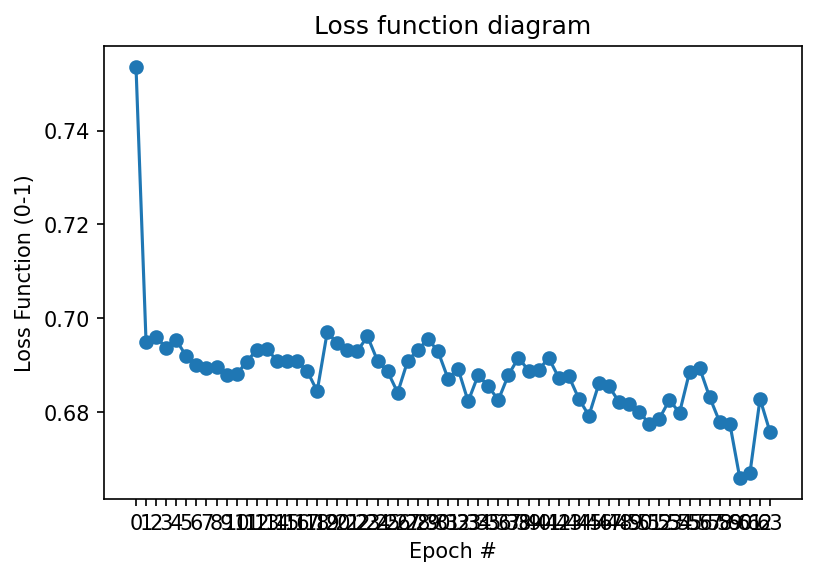

In [21]:
# 获取训练过程的损失值
loss_1 = my_model.history.history
print(loss_1)
def plot(lrs,title="Loss function diagram"):
    #计算学习率随epoch的变化值
    epochs=np.arange(len(lrs))
    plt.figure(dpi=150)
    plt.plot(epochs,lrs)
    plt.xticks(epochs)
    plt.scatter(epochs,lrs)
    plt.title(title)
    plt.xlabel("Epoch #")
    plt.ylabel("Loss Function (0-1)")
# print(my_model.history.history)
plot(my_model.history.history['loss'])
plt.savefig('Loss_function_diagram_cat_3.png')


In [23]:
# 6、保存模型
# from sklearn.externals import joblib
# joblib.dump(my_model, "../../model/AR-8-8-adam-mse-60-30.pkl")
# my_model.save("../../model/AR-16-100-adam-mse-60-2-unseq.h5")
# my_model.save("../../model/AR-16-32-60-Adadelta-mse2-seq.h5")
# my_model.save("../../model/Cat-16-16-adam-bce-seq.h5")
# my_model.save("../../model/Cat-16-4-adam-bce-seq.h5")
# my_model.save("../../model/Cat-32-64-adam-bce-seq.h5")
model.save("../../model/Cat-128-800-adam-bce-seq-BN8.h5")

# 只保存网络结构
# # 保存为 JSON
# json_string = my_model.to_json()
# print(json_string)
# # 保存为 YAML
# yaml_string = my_model.to_yaml()
# print(yaml_string)
# 7、模型的加载使用
# from keras.models import load_model
# model = load_model('AR-8-8-adam-mse-60-30.h5')
# model = joblib.load("model/k_near.pkl")

# # 从 JSON 重建模型：
# from keras.models import model_from_json
# model = model_from_json(json_string)
 
# # 从 YAML 重建模型：
# from keras.models import model_from_yaml
# model = model_from_yaml(yaml_string)

# 模型测试

In [24]:
my_model = model

#test
print('\nTesting~~~~~~~~')
scores = my_model.evaluate(trainX,trainY, verbose=1)
print('train loss:', scores[0])
print('train accuracy:', scores[1])
# https://pythontechworld.com/issue/649453932/chinese-text-classification-pytorch/82
metrics = my_model.evaluate(testX,testY,verbose=1)#, batch_size=16) #,batch_size=40)
print('Test loss:', metrics[0])
print('Test accuracy:', metrics[1])


Testing~~~~~~~~
9960/9960 [==============================] - 4s 410us/sample - loss: 0.5425 - acc: 0.7008
train loss: 0.5424549262267518
train accuracy: 0.7008032
2520/2520 [==============================] - 1s 391us/sample - loss: 0.8546 - acc: 0.5329
Test loss: 0.8546350390192062
Test accuracy: 0.5329365


In [25]:
# 测试集模型预测
# test_x = testX[-1,-len(prediction):,0].reshape(-1, 1)
# prediction=my_model.predict(testX)
# my_model = model
pre=my_model.predict(testX)
print(type(pre))
# 异常值处理
prediction = []
for x in range(0,len(pre)):
    xx = pre[x]
    if xx > 0.51:
        prediction.append([1])
    else:
        prediction.append(np.round(xx)) # 四舍五入
#         prediction.append([0])
        
# print(prediction)
prediction = np.array(prediction)
# print('testY shape:',testY.shape,type(testY))#(12963,)
# print("Prediction Shape:",prediction.shape,type(prediction)) # (12963, 1)
# bbb = np.unique(prediction)
# print('测试集所用样本个数：',len(bbb))
# ccc,ddd =  np.percentile(prediction, [0, 100])
# print(ccc,ddd)
# 测试集评价指标
def eva_ind(data_gt,data_pre):
    
    gt = data_gt
    pre = data_pre
    pre_mean = np.mean(gt)

    # 获取绝对值误差
    Abs = []
    Abs_error = []
    for i in range(0,len(gt)):
    #     print(i)
        Abs.append(abs(pre[i]-gt[i])) # 绝对误差
        Abs_error.append(abs(gt[i]-pre_mean)) # 标签-预测平均值

    mse = mean_squared_error(pre, gt) # 均方误差
    rmse = np.sqrt(mean_squared_error(pre, gt)) # 根均方误差
    r2_s = r2_score(gt, pre) # 决定系数，反映因变量的全部变异能通过回归关系被自变量解释的比例

    # 平均偏差
    pre_mean_error = np.mean(Abs_error)
    # print(pre_mean_error)
    # 平均误差除以预测集平均值
    relative_error =  pre_mean_error/ pre_mean   

    # 平均绝对值误差（mean_absolute_error）
    mae =  mean_absolute_error(gt,pre)
        # 真实值与
    print(f"测试集均方误差(MSE)：{mse}")
    print(f"测试集根均方误差(RMSE)：{rmse}")
    print(f"测试集平均绝对误差：{mae}")
    print(f"测试集R^2：{r2_s}")
    print(f"测试集相对平均误差：{relative_error*100}%")
print('---')
eva_ind(testY,prediction)
# print(prediction)

'''
---
测试集均方误差(MSE)：0.2688409057274242
测试集根均方误差(RMSE)：0.5184987036892418
测试集平均绝对误差：0.503803246669353
测试集R^2：-0.07536362290969678
测试集相对平均误差：100.0%
'''

<class 'numpy.ndarray'>
---
测试集均方误差(MSE)：0.46706349206349207
测试集根均方误差(RMSE)：0.683420435795925
测试集平均绝对误差：0.46706349206349207
测试集R^2：-0.8682539682539683
测试集相对平均误差：100.0%


'\n---\n测试集均方误差(MSE)：0.2688409057274242\n测试集根均方误差(RMSE)：0.5184987036892418\n测试集平均绝对误差：0.503803246669353\n测试集R^2：-0.07536362290969678\n测试集相对平均误差：100.0%\n'

In [26]:
from keras.models import load_model
 
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score
 
# print(prediction)
def evaluation(testY,prediction):
 
    # 测试
    # model=load_model('./models/lenet5_weight.h5')

    # y_predict = model.predict(x_test, batch_size=512, verbose=1)
    # y_predict = (y_predict > 0.007).astype(int)
    # y_predict = (y_predict > 0.01).astype(int)
    y_true = np.reshape(testY, [-1])
    y_pred = np.reshape(prediction, [-1])

    # 评价指标
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1score = f1_score(y_true, y_pred, average='macro')

    # Micro F1: 将n分类的评价拆成n个二分类的评价，将n个二分类评价的TP、FP、RN对应相加，计算评价准确率和召回率，由这2个准确率和召回率计算的F1 score即为Micro F1。
    # Macro F1: 将n分类的评价拆成n个二分类的评价，计算每个二分类的F1 score，n个F1 score的平均值即为Macro F1。
    # 一般来讲，Macro F1、Micro F1高的分类效果好。Macro F1受样本数量少的类别影响大。
    micro_f1 = f1_score(y_true, y_pred,average='micro')
    macro_f1 = f1_score(y_true, y_pred,average='macro')


    print('accuracy:',accuracy)
    print('precision:',precision)
    print('recall:',recall)
    print('f1score:',f1score)
    print('Macro-F1: {}'.format(macro_f1))
    print('Micro-F1: {}'.format(micro_f1))
    

evaluation(testY,prediction)

accuracy: 0.5329365079365079
precision: 0.5354741521718336
recall: 0.5329365079365079
f1score: 0.5244315582705383
Macro-F1: 0.5244315582705383
Micro-F1: 0.5329365079365079


四舍五入
accuracy: 0.5496031746031746
precision: 0.555509385844155
recall: 0.5496031746031746
f1score: 0.5372952007116744
Macro-F1: 0.5372952007116744
Micro-F1: 0.5496031746031746

0.333
accuracy: 0.5027777777777778
precision: 0.659788398130367
recall: 0.5027777777777778
f1score: 0.3408565758301135
Macro-F1: 0.3408565758301135
Micro-F1: 0.5027777777777778

0.49
accuracy: 0.5297619047619048
precision: 0.5370553650286758
recall: 0.5297619047619048
f1score: 0.5054256276044777
Macro-F1: 0.5054256276044777
Micro-F1: 0.5297619047619048

0.5
accuracy: 0.5496031746031746
precision: 0.555509385844155
recall: 0.5496031746031746
f1score: 0.5372952007116744
Macro-F1: 0.5372952007116744
Micro-F1: 0.5496031746031746

0.51
accuracy: 0.5492063492063493
precision: 0.5509640902792456
recall: 0.5492063492063493
f1score: 0.5452855974702508
Macro-F1: 0.5452855974702508
Micro-F1: 0.5492063492063493